# Data Preparation and Basic EDA

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
# Custom imports and styles
import utils
import eda_utils
import model_utils
from importlib import reload

In [143]:
reload(model_utils);

In [3]:
plt.style.use('./styles.txt')

## Introduction

**TODO**

## Data Loading and Cleaning

In [16]:
# Load data
df_raw = pd.read_pickle('sample_data/30k_wildfires_weather_emissions.pkl')

In [17]:
df_raw.drop('index', axis=1, inplace=True)
df_raw.head(2)

DATE  FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE FIRE_SIZE_CLASS  LATITUDE  \
0 1992-01-01       1992              1        0.1               A   43.3250   
1 1992-01-01       1992              1        3.0               B   33.0634   

    LONGITUDE STATE                                     tempmax  avg_tempmax  \
0 -101.018500    SD         [6.7, 6.7, 1.7, 7.2, 8.4, 1.7, 4.4]     5.257143   
1  -90.120813    MS  [16.7, 13.4, 10.7, 11.7, 12.2, 10.7, 15.7]    13.014286   

   ...   avg_dew                                   windspeed avg_windspeed  \
0  ... -6.071429  [13.0, 22.3, 31.7, 20.5, 11.2, 18.7, 11.2]     18.371429   
1  ...  3.771429  [14.8, 18.4, 14.8, 14.8, 18.4, 22.3, 11.2]     16.385714   

                                             winddir avg_winddir  \
0  [295.9, 179.8, 186.4, 218.7, 263.2, 173.2, 247.3]       223.5   
1        [25.9, 46.9, 303.3, 10.4, 29.3, 36.9, 70.2]        74.7   

                                            pressure avg_pressure  \
0  [1026.9, 1029.2, 1017.7, 1012.2, 1019.1, 1024....  1021.671429   
1  [1023.4, 1023.0, 1019.5, 1020.8, 1024.5, 1027....  1023.442857   

            ch4           co2           n2o  
0  4.613353e-11  3.672947e-09  3.926278e-12  
1  1.679468e-11  3.891437e-09  1.957145e-12  

[2 rows x 27 columns]

In [18]:
eda_utils.BasicEda(df_raw, 'Extended Wildfire Data', ['shape', 'null', 'columns', 'dtypes'])

EXTENDED WILDFIRE DATA
----------------------

Rows: 30000    Columns: 27

Total null rows: 0
Percentage null rows:  0.000%

DATE               datetime64[ns]
FIRE_YEAR                   int64
DISCOVERY_DOY               int64
FIRE_SIZE                 float64
FIRE_SIZE_CLASS            object
LATITUDE                  float64
LONGITUDE                 float64
STATE                      object
tempmax                    object
avg_tempmax               float64
temp                       object
avg_temp                  float64
humidity                   object
avg_humidity              float64
precip                     object
avg_precip                float64
dew                        object
avg_dew                   float64
windspeed                  object
avg_windspeed             float64
winddir                    object
avg_winddir               float64
pressure                   object
avg_pressure              float64
ch4                       float64
co2                      

In [19]:
df_raw.isna().sum()

DATE                  0
FIRE_YEAR             0
DISCOVERY_DOY         0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
LATITUDE              0
LONGITUDE             0
STATE                 0
tempmax               0
avg_tempmax           2
temp                  0
avg_temp            947
humidity              0
avg_humidity       1004
precip                0
avg_precip         4354
dew                   0
avg_dew            1004
windspeed             0
avg_windspeed       940
winddir               0
avg_winddir        4144
pressure              0
avg_pressure       3594
ch4                   0
co2                   0
n2o                   0
dtype: int64

Assume they can't be imputed, we will remove all of them, however accounted for this by loading a large enough sample that we are left with a good amount of values.

Get the indexes of all the null values to see how much data we would lose.

In [21]:
cumulative_cols = ['tempmax', 'temp', 'humidity', 'precip', 'dew', 'winddir', 'pressure']

indexes = []

for index, row in df_raw.iterrows():
    for col in cumulative_cols:
        if True in np.isnan(row[col]):
            indexes.append(index)
            break
            
print(len(indexes))

9149


Unfortunately, we see that we will be removing approximately 29% of our data, however we knew that this would happen which is why we created a large sample from which to work from. We will therefore remove these values.

In [24]:
# Drop these indexes from our data
df_raw.drop(index=indexes, inplace=True)

In [25]:
df_raw.isna().sum()

DATE               0
FIRE_YEAR          0
DISCOVERY_DOY      0
FIRE_SIZE          0
FIRE_SIZE_CLASS    0
LATITUDE           0
LONGITUDE          0
STATE              0
tempmax            0
avg_tempmax        0
temp               0
avg_temp           0
humidity           0
avg_humidity       0
precip             0
avg_precip         0
dew                0
avg_dew            0
windspeed          0
avg_windspeed      0
winddir            0
avg_winddir        0
pressure           0
avg_pressure       0
ch4                0
co2                0
n2o                0
dtype: int64

In [26]:
df_raw.shape

(20851, 27)

In [30]:
df_cleaned = df_raw.copy()

## Creating Additional Features

One of the main reasons that we included the list within the DataFrame was to allow us to create new features from the weather information without having to collect data through the API again. one of the variables that we are able to create is the variance for each of the weather points. The variance will hopefully indicate how significantly the weather changed in the days prior to the wildfire.

In [31]:
week_data = [
    'tempmax',
    'temp',
    'humidity',
    'precip',
    'dew',
    'windspeed',
    'winddir',
    'pressure'
]

In [32]:
for metric in week_data:
    variance_col_name = f'{metric}_variance'
    df_cleaned[variance_col_name] = df_cleaned[metric].apply(lambda x: np.var(x))
    
    delta_col_name = f'{metric}_delta'
    df_cleaned[delta_col_name] = df_cleaned[metric].apply(lambda x: x[-1] - x[0])

In [33]:
df_cleaned.head()

DATE  FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE FIRE_SIZE_CLASS   LATITUDE  \
0 1992-01-01       1992              1       0.10               A  43.325000   
2 1992-01-01       1992              1       1.00               B  33.058333   
3 1992-01-02       1992              2       0.25               A  40.775000   
5 1992-01-03       1992              3       1.91               B  31.018500   
6 1992-01-03       1992              3       2.00               B  30.728900   

    LONGITUDE STATE                                     tempmax  avg_tempmax  \
0 -101.018500    SD         [6.7, 6.7, 1.7, 7.2, 8.4, 1.7, 4.4]     5.257143   
2  -79.979167    SC  [10.8, 11.2, 16.0, 15.9, 13.9, 12.6, 15.5]    13.700000   
3  -74.854160    NJ         [7.8, 8.0, 7.5, 6.4, 2.3, 5.0, 7.7]     6.385714   
5  -83.297300    GA   [15.1, 15.6, 9.8, 16.0, 13.2, 16.7, 14.8]    14.457143   
6  -87.238100    FL  [16.9, 12.6, 11.6, 14.9, 14.7, 15.9, 14.4]    14.428571   

   ... precip_variance  precip_delta dew_variance  dew_delta  \
0  ...        0.000000          0.00     5.399184        3.5   
2  ...       55.589796         -4.40     7.196327        0.1   
3  ...        9.546510          0.00    19.731020        4.0   
5  ...       59.321224         -9.70     9.142041       -4.1   
6  ...        0.213355         -1.32    10.262857       -7.9   

  windspeed_variance  windspeed_delta winddir_variance  winddir_delta  \
0          47.062041             -1.8      1889.074286          -48.6   
2           5.575510              2.0     15648.559592          -14.9   
3          34.516735            -10.6     16492.948163         -254.6   
5          11.228571              0.2     16679.204898          223.6   
6          27.382857              6.7     19587.093469          -24.8   

  pressure_variance  pressure_delta  
0         28.913469            -4.3  
2         19.071020             2.4  
3         75.711429            -0.9  
5         21.585306            -8.4  
6         13.107755            -2.7  

[5 rows x 43 columns]

In [34]:
# Sanity check to make sure that we have no null values in the data set
df_cleaned.isna().sum()

DATE                  0
FIRE_YEAR             0
DISCOVERY_DOY         0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
LATITUDE              0
LONGITUDE             0
STATE                 0
tempmax               0
avg_tempmax           0
temp                  0
avg_temp              0
humidity              0
avg_humidity          0
precip                0
avg_precip            0
dew                   0
avg_dew               0
windspeed             0
avg_windspeed         0
winddir               0
avg_winddir           0
pressure              0
avg_pressure          0
ch4                   0
co2                   0
n2o                   0
tempmax_variance      0
tempmax_delta         0
temp_variance         0
temp_delta            0
humidity_variance     0
humidity_delta        0
precip_variance       0
precip_delta          0
dew_variance          0
dew_delta             0
windspeed_variance    0
windspeed_delta       0
winddir_variance      0
winddir_delta         0
pressure_varianc

In [37]:
# Check duplicate values
df_cleaned.drop(week_data, axis=1).duplicated().sum()

0

In [43]:
df_cleaned.drop(week_data, axis=1, inplace=True)

In [192]:
df_cleaned.reset_index(drop=True, inplace=True)

#### Saving the DataFrame

In [194]:
# df_cleaned.to_pickle('sample_data/30k_engineered.pkl')

## Preprocessing

First, we will separate into *numeric* and *categorical* columns, working on these individually and eventually combining them.

In [61]:
# numeric_df = df_cleaned.select_dtypes('number').copy()
categorical_df = df_cleaned.select_dtypes('object').copy()

In [46]:
print("Numeric columns: \n", ',\n '.join(numeric_df.columns))
print("")
print("Categorical columns: \n", ', \n '.join(categorical_df.columns))

Numeric columns: 
 FIRE_YEAR,
 DISCOVERY_DOY,
 FIRE_SIZE,
 LATITUDE,
 LONGITUDE,
 avg_tempmax,
 avg_temp,
 avg_humidity,
 avg_precip,
 avg_dew,
 avg_windspeed,
 avg_winddir,
 avg_pressure,
 ch4,
 co2,
 n2o,
 tempmax_variance,
 tempmax_delta,
 temp_variance,
 temp_delta,
 humidity_variance,
 humidity_delta,
 precip_variance,
 precip_delta,
 dew_variance,
 dew_delta,
 windspeed_variance,
 windspeed_delta,
 winddir_variance,
 winddir_delta,
 pressure_variance,
 pressure_delta

Categorical columns: 
 FIRE_SIZE_CLASS, 
 STATE


In [47]:
numeric_df.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
2       1992              1       1.00  33.058333  -79.979167    13.700000   
3       1992              2       0.25  40.775000  -74.854160     6.385714   
5       1992              3       1.91  31.018500  -83.297300    14.457143   
6       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  precip_variance  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         0.000000   
2   9.885714     81.428571    4.185714  6.671429  ...        55.589796   
3   1.585714     67.185714    1.394286 -4.242857  ...         9.546510   
5  11.828571     78.957143    4.685714  8.128571  ...        59.321224   
6  10.985714     79.971429    0.188571  7.500000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      5.399184        3.5           47.062041             -1.8   
2         -4.40      7.196327        0.1            5.575510              2.0   
3          0.00     19.731020        4.0           34.516735            -10.6   
5         -9.70      9.142041       -4.1           11.228571              0.2   
6         -1.32     10.262857       -7.9           27.382857              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0       1889.074286          -48.6          28.913469            -4.3  
2      15648.559592          -14.9          19.071020             2.4  
3      16492.948163         -254.6          75.711429            -0.9  
5      16679.204898          223.6          21.585306            -8.4  
6      19587.093469          -24.8          13.107755            -2.7  

[5 rows x 32 columns]

In [65]:
categorical_df.head()

FIRE_SIZE_CLASS STATE
0               A    SD
2               B    SC
3               A    NJ
5               B    GA
6               B    FL

### Preprocessing Categorical Data

In this stage, we will plan to numerically encode categorical variables. We will only consider the first 2 columns (`FIRE_SIZE_CLASS` and `STATE`) 

In [66]:
categorical_df.nunique().sort_values()

FIRE_SIZE_CLASS     7
STATE              52
dtype: int64

We will begin by processing `FIRE_SIZE_CLASS`.

#### Processing `FIRE_SIZE_CLASS`

In [67]:
utils.count_percentage_df(categorical_df['FIRE_SIZE_CLASS'])

Count  Percentage of Total
B  10529             0.504964
A   7355             0.352741
C   2441             0.117069
D    299             0.014340
E    140             0.006714
F     56             0.002686
G     31             0.001487

We see that our classes are imbalanced, with class B having the highest proportion of all the classes. However, since they represent size, we will encode them with a numeric scale, based on the size (alphabetic order) 

In [68]:
categorical_df['FIRE_SIZE_NUMERIC'] = \
categorical_df['FIRE_SIZE_CLASS'].map(
    {'A': 1,'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
)

Assert that the mapping has maintained the same distribution.

In [69]:
try:
    pd.testing.assert_series_equal(categorical_df['FIRE_SIZE_NUMERIC'].value_counts(), 
                                   categorical_df['FIRE_SIZE_CLASS'].value_counts(),
                                   check_names=False, check_index=False)
    print ("Series are equal.")
except:
    print ("Series are not equal.")

Series are equal.


#### Processing `STATE`

As expected, there are 50 states within this data set which can be encoded using dummy variables.

In [70]:
state_dummies = pd.get_dummies(categorical_df['STATE'], prefix='state')
state_dummies.head()

state_AK  state_AL  state_AR  state_AZ  state_CA  state_CO  state_CT  \
0         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
5         0         0         0         0         0         0         0   
6         0         0         0         0         0         0         0   

   state_DC  state_DE  state_FL  ...  state_SD  state_TN  state_TX  state_UT  \
0         0         0         0  ...         1         0         0         0   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
5         0         0         0  ...         0         0         0         0   
6         0         0         1  ...         0         0         0         0   

   state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  
0         0         0         0         0         0         0  
2         0         0         0         0         0         0  
3         0         0         0         0         0         0  
5         0         0         0         0         0         0  
6         0         0         0         0         0         0  

[5 rows x 52 columns]

In [71]:
categorical_df = pd.concat([categorical_df, state_dummies], axis=1)
categorical_df.head()

FIRE_SIZE_CLASS STATE  FIRE_SIZE_NUMERIC  state_AK  state_AL  state_AR  \
0               A    SD                  1         0         0         0   
2               B    SC                  2         0         0         0   
3               A    NJ                  1         0         0         0   
5               B    GA                  2         0         0         0   
6               B    FL                  2         0         0         0   

   state_AZ  state_CA  state_CO  state_CT  ...  state_SD  state_TN  state_TX  \
0         0         0         0         0  ...         1         0         0   
2         0         0         0         0  ...         0         0         0   
3         0         0         0         0  ...         0         0         0   
5         0         0         0         0  ...         0         0         0   
6         0         0         0         0  ...         0         0         0   

   state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  
0         0         0         0         0         0         0         0  
2         0         0         0         0         0         0         0  
3         0         0         0         0         0         0         0  
5         0         0         0         0         0         0         0  
6         0         0         0         0         0         0         0  

[5 rows x 55 columns]

In [72]:
categorical_df.drop('STATE', axis=1, inplace=True)

In [73]:
categorical_df.head(2)

FIRE_SIZE_CLASS  FIRE_SIZE_NUMERIC  state_AK  state_AL  state_AR  state_AZ  \
0               A                  1         0         0         0         0   
2               B                  2         0         0         0         0   

   state_CA  state_CO  state_CT  state_DC  ...  state_SD  state_TN  state_TX  \
0         0         0         0         0  ...         1         0         0   
2         0         0         0         0  ...         0         0         0   

   state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  
0         0         0         0         0         0         0         0  
2         0         0         0         0         0         0         0  

[2 rows x 54 columns]

### Processing Numerical Columns

In [59]:
numeric_df.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
2       1992              1       1.00  33.058333  -79.979167    13.700000   
3       1992              2       0.25  40.775000  -74.854160     6.385714   
5       1992              3       1.91  31.018500  -83.297300    14.457143   
6       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  precip_variance  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         0.000000   
2   9.885714     81.428571    4.185714  6.671429  ...        55.589796   
3   1.585714     67.185714    1.394286 -4.242857  ...         9.546510   
5  11.828571     78.957143    4.685714  8.128571  ...        59.321224   
6  10.985714     79.971429    0.188571  7.500000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      5.399184        3.5           47.062041             -1.8   
2         -4.40      7.196327        0.1            5.575510              2.0   
3          0.00     19.731020        4.0           34.516735            -10.6   
5         -9.70      9.142041       -4.1           11.228571              0.2   
6         -1.32     10.262857       -7.9           27.382857              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0       1889.074286          -48.6          28.913469            -4.3  
2      15648.559592          -14.9          19.071020             2.4  
3      16492.948163         -254.6          75.711429            -0.9  
5      16679.204898          223.6          21.585306            -8.4  
6      19587.093469          -24.8          13.107755            -2.7  

[5 rows x 32 columns]

In [60]:
utils.HistogramSubplots(numeric_df.drop('FIRE_SIZE', axis=1))

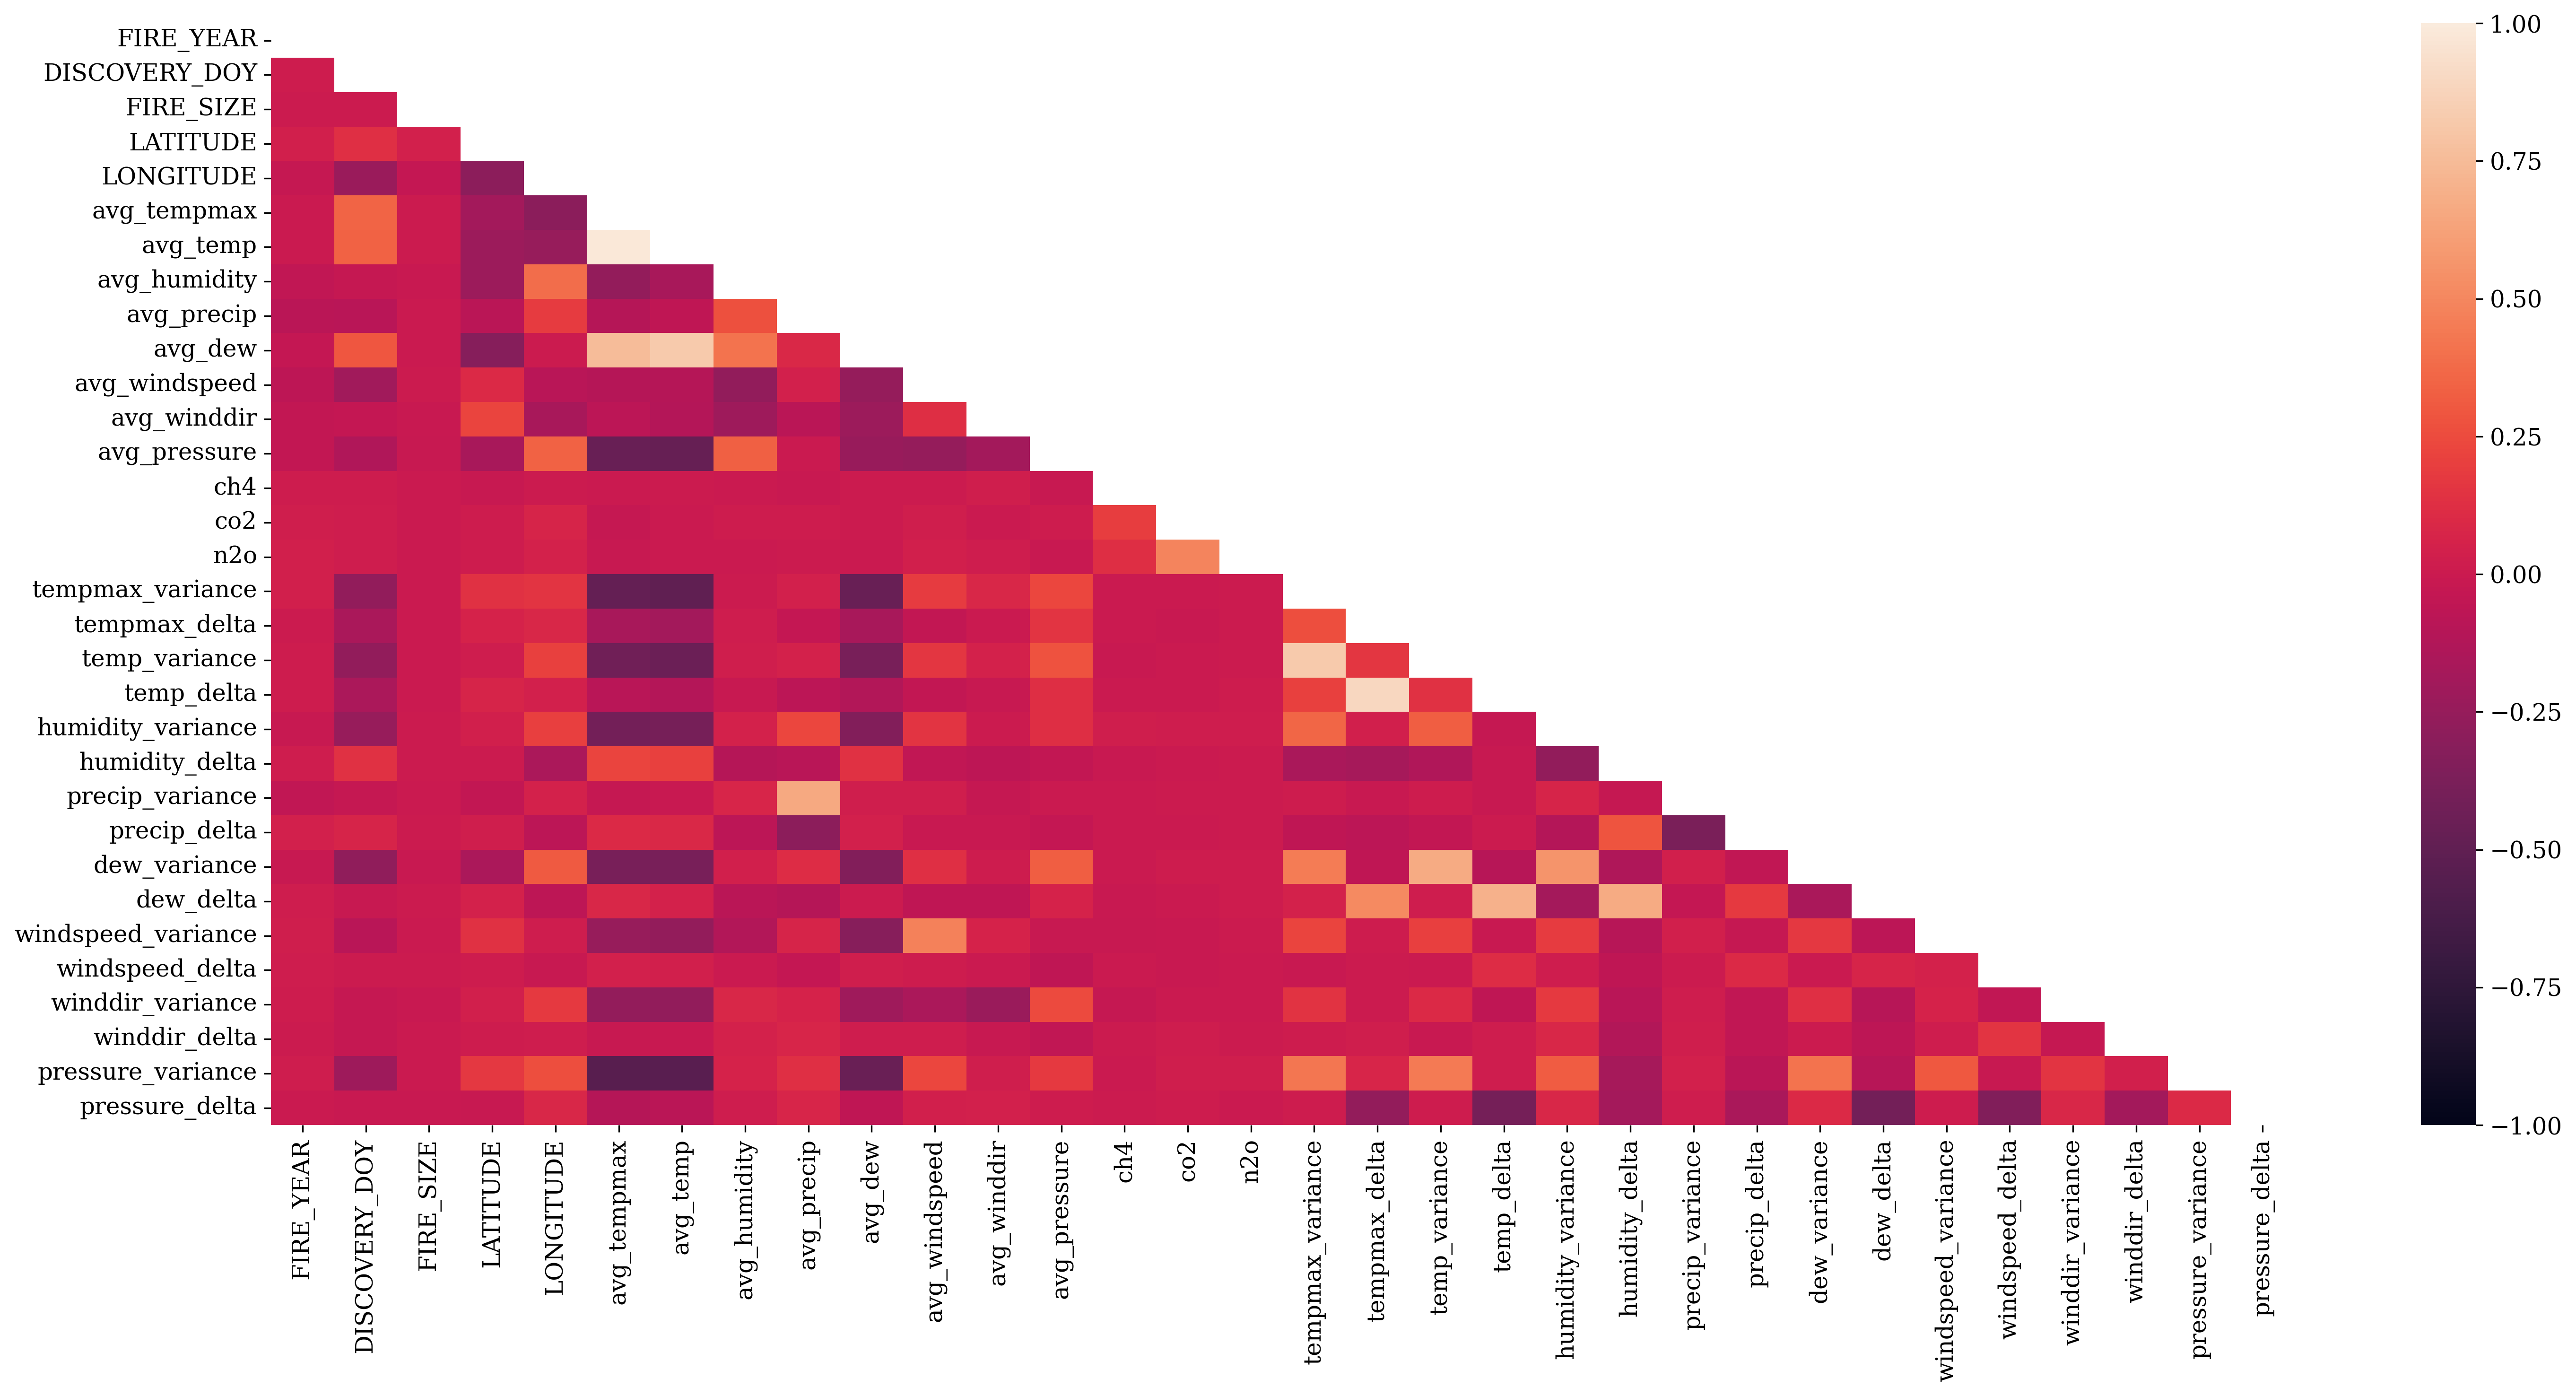

In [63]:
# Plot the correlation using a heatmap
corr = numeric_df.corr()

plt.figure(figsize=(20,10), dpi=300)
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, vmin=-1, vmax=1)
plt.show()

As we can see, initially, there is very little correlation between the values in our data set. Presumably this is because the scale of the fire data, which is heavily skewed.

## Exploring relationships between variables

On the basis of the previous exploration, can any be used to predict the others? To figure this out, it helps to begin by plotting variables against each other, to visualize the relationship between them.

In [74]:
X_input = numeric_df.drop('FIRE_SIZE', axis=1)
X_input.head()

FIRE_YEAR  DISCOVERY_DOY   LATITUDE   LONGITUDE  avg_tempmax   avg_temp  \
0       1992              1  43.325000 -101.018500     5.257143  -2.928571   
2       1992              1  33.058333  -79.979167    13.700000   9.885714   
3       1992              2  40.775000  -74.854160     6.385714   1.585714   
5       1992              3  31.018500  -83.297300    14.457143  11.828571   
6       1992              3  30.728900  -87.238100    14.428571  10.985714   

   avg_humidity  avg_precip   avg_dew  avg_windspeed  ...  precip_variance  \
0     81.142857    0.000000 -6.071429      18.371429  ...         0.000000   
2     81.428571    4.185714  6.671429      23.514286  ...        55.589796   
3     67.185714    1.394286 -4.242857      18.157143  ...         9.546510   
5     78.957143    4.685714  8.128571      19.200000  ...        59.321224   
6     79.971429    0.188571  7.500000      17.000000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      5.399184        3.5           47.062041             -1.8   
2         -4.40      7.196327        0.1            5.575510              2.0   
3          0.00     19.731020        4.0           34.516735            -10.6   
5         -9.70      9.142041       -4.1           11.228571              0.2   
6         -1.32     10.262857       -7.9           27.382857              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0       1889.074286          -48.6          28.913469            -4.3  
2      15648.559592          -14.9          19.071020             2.4  
3      16492.948163         -254.6          75.711429            -0.9  
5      16679.204898          223.6          21.585306            -8.4  
6      19587.093469          -24.8          13.107755            -2.7  

[5 rows x 31 columns]

In [77]:
from math import ceil

columns = 4
rows = ceil(len(X_input.columns) / columns)

plt.subplots(rows, columns, figsize=(30,30), dpi=300)

for index, col in enumerate(X_input):
    position = index + 1
    plt.subplot(rows, columns, position)
    sns.histplot(x=X_input[col], 
                 y=df_cleaned['FIRE_SIZE_CLASS'],
                 kde=True)

plt.tight_layout()
plt.show()

## Baseline Linear Regression

In order to build this model there are a few things that we have to do before hand. First, we need to format the data - this includes transformations on skewed data using Boxcox.

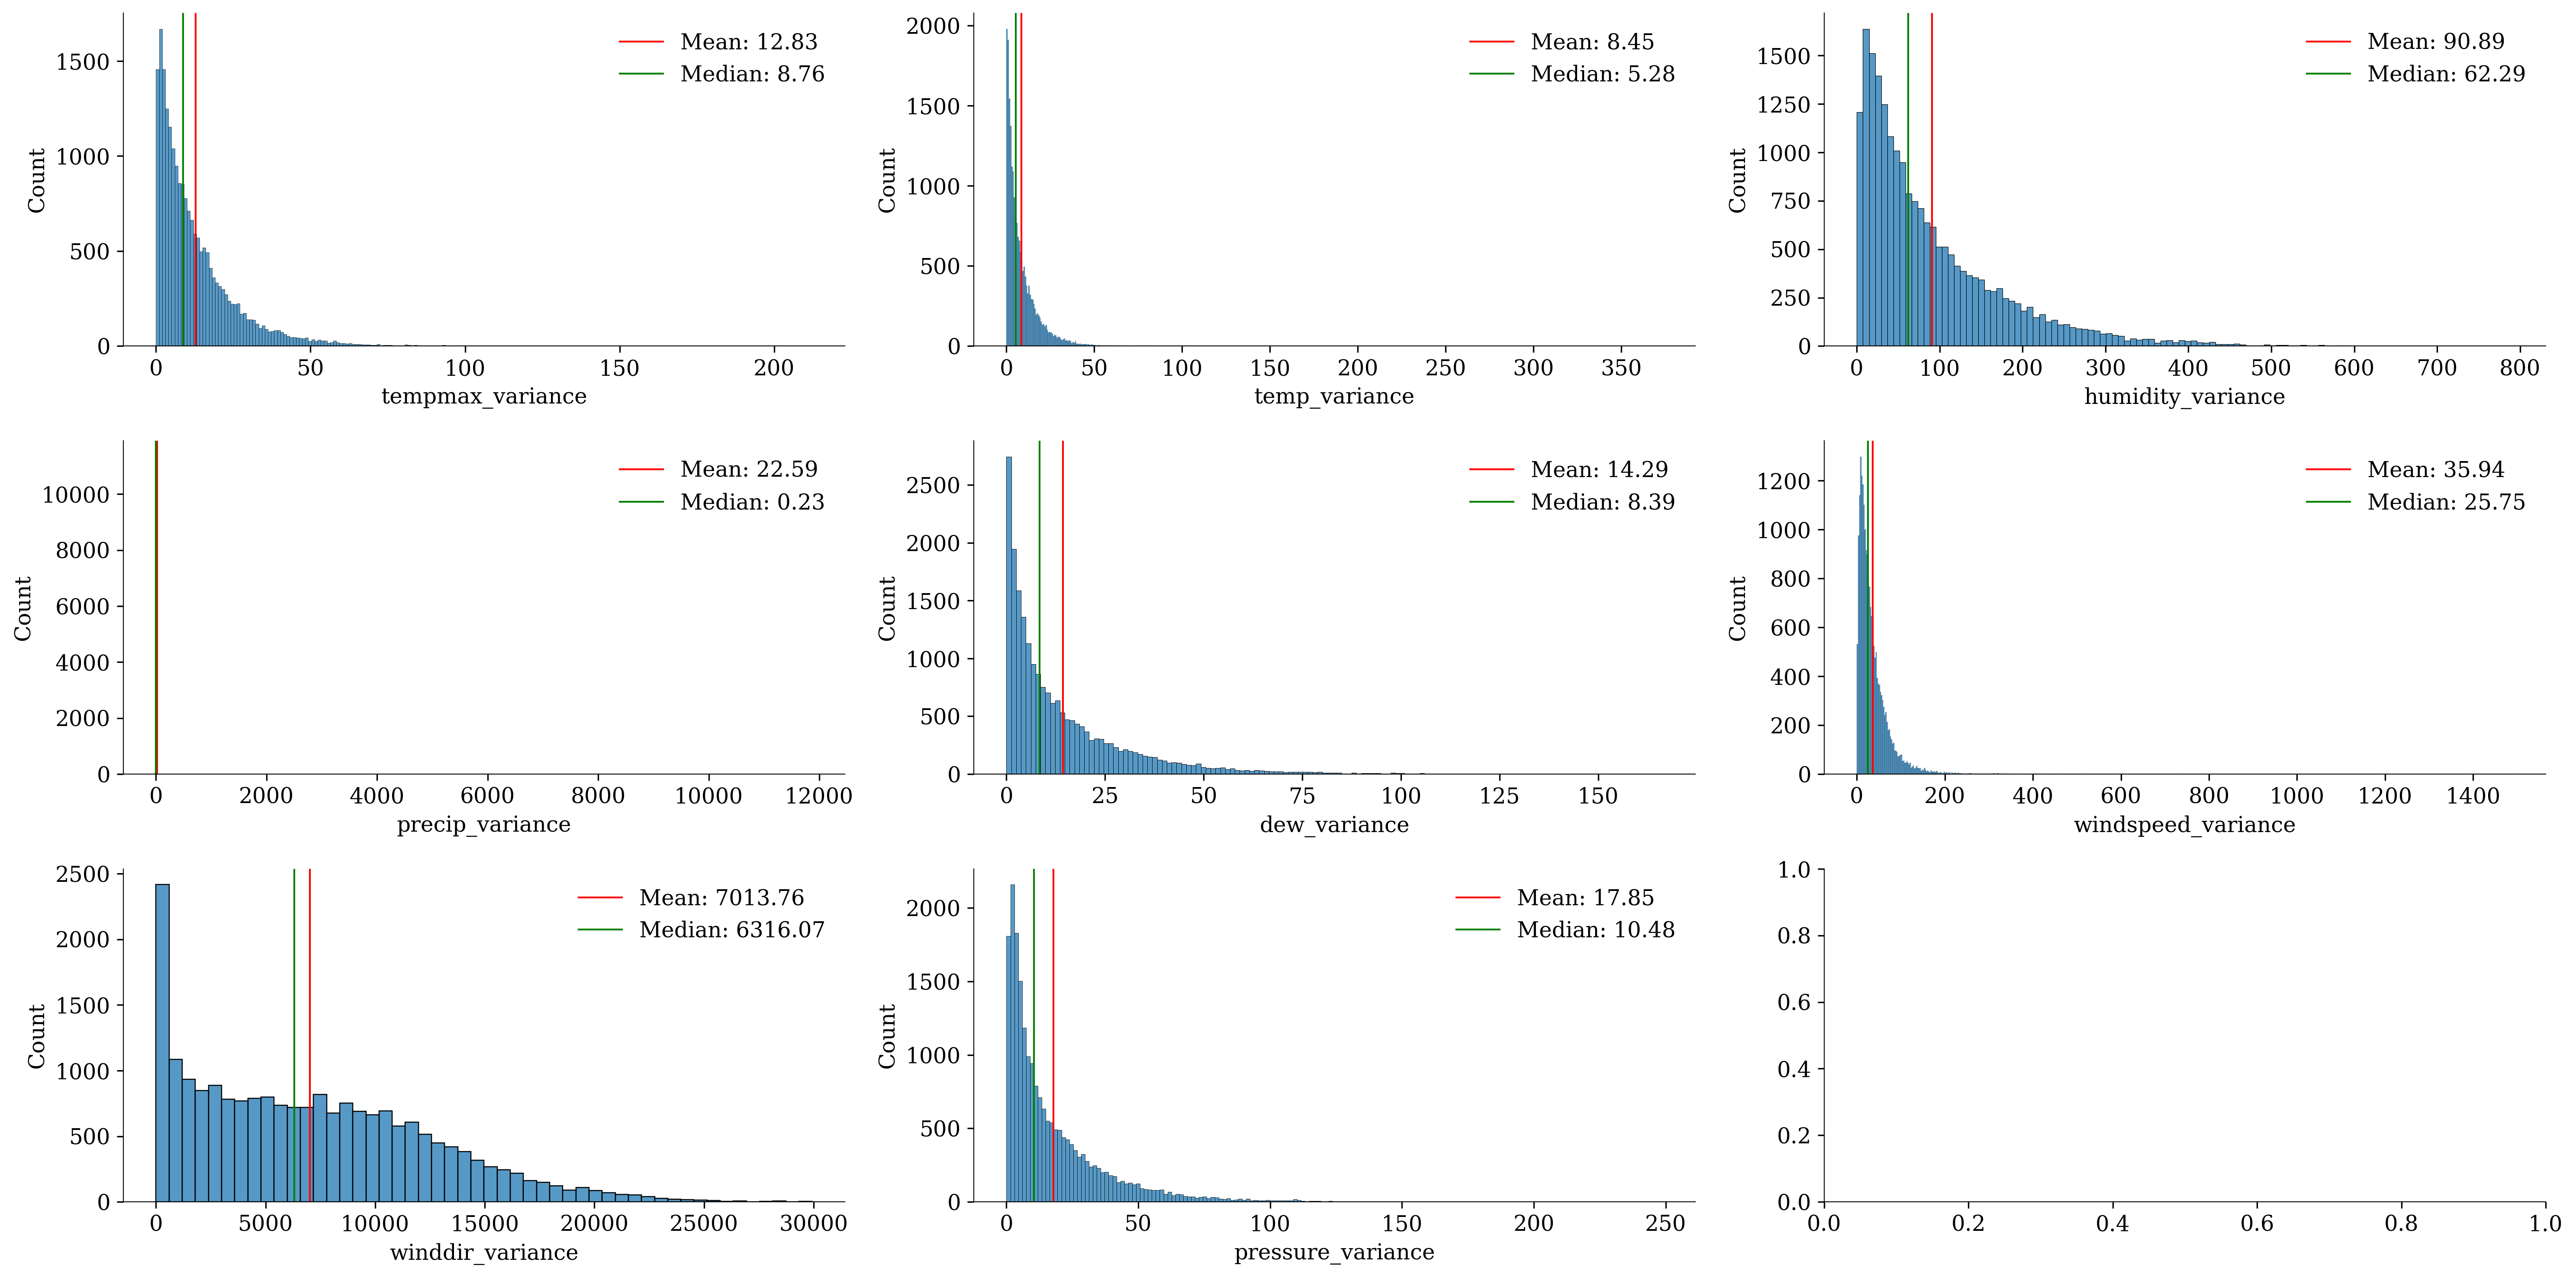

In [81]:
boxcox_cols = [col for col in numeric_df.columns
               if 'variance' in col]

utils.HistogramSubplots(numeric_df[boxcox_cols], figsize=(20, 15))

For our linear regression model we require the columns to be normal - these are heavily right skewed, meaning they do not conform to our assumptions of a linear regression. We can transform these columns using a Box-cox transformation to see whether we are able to normalise their distribution. To do Box-Cox, the variables need to be greater than 0. Let us look at the variables and see whether they fall within the range:

In [82]:
numeric_df[boxcox_cols].describe().T

count         mean          std       min          25%  \
tempmax_variance    20851.0    12.828399    13.465794  0.001224     3.499184   
temp_variance       20851.0     8.447304     9.943393  0.012653     1.989796   
humidity_variance   20851.0    90.893124    88.044584  0.187755    26.417959   
precip_variance     20851.0    22.594312   176.365582  0.000000     0.000000   
dew_variance        20851.0    14.291504    16.451731  0.016735     2.851429   
windspeed_variance  20851.0    35.944840    37.009957  0.291020    12.849592   
winddir_variance    20851.0  7013.763855  5415.470092  0.757143  2344.036327   
pressure_variance   20851.0    17.848506    20.582998  0.033878     3.977551   

                            50%           75%           max  
tempmax_variance       8.756327     17.403673    212.282449  
temp_variance          5.276327     11.563265    373.487755  
humidity_variance     62.291020    128.072857    791.417143  
precip_variance        0.225441      6.803071  11870.070612  
dew_variance           8.393469     19.834898    166.250612  
windspeed_variance    25.747755     47.240612   1490.442449  
winddir_variance    6316.071020  10643.864694  29931.213469  
pressure_variance     10.481224     24.478776    248.764082

We see that the minimum value for precipitation is 0, meaning that we need to remove this from the transformations. Before we change it in the`processed_df`, we should see how the transformation works out.

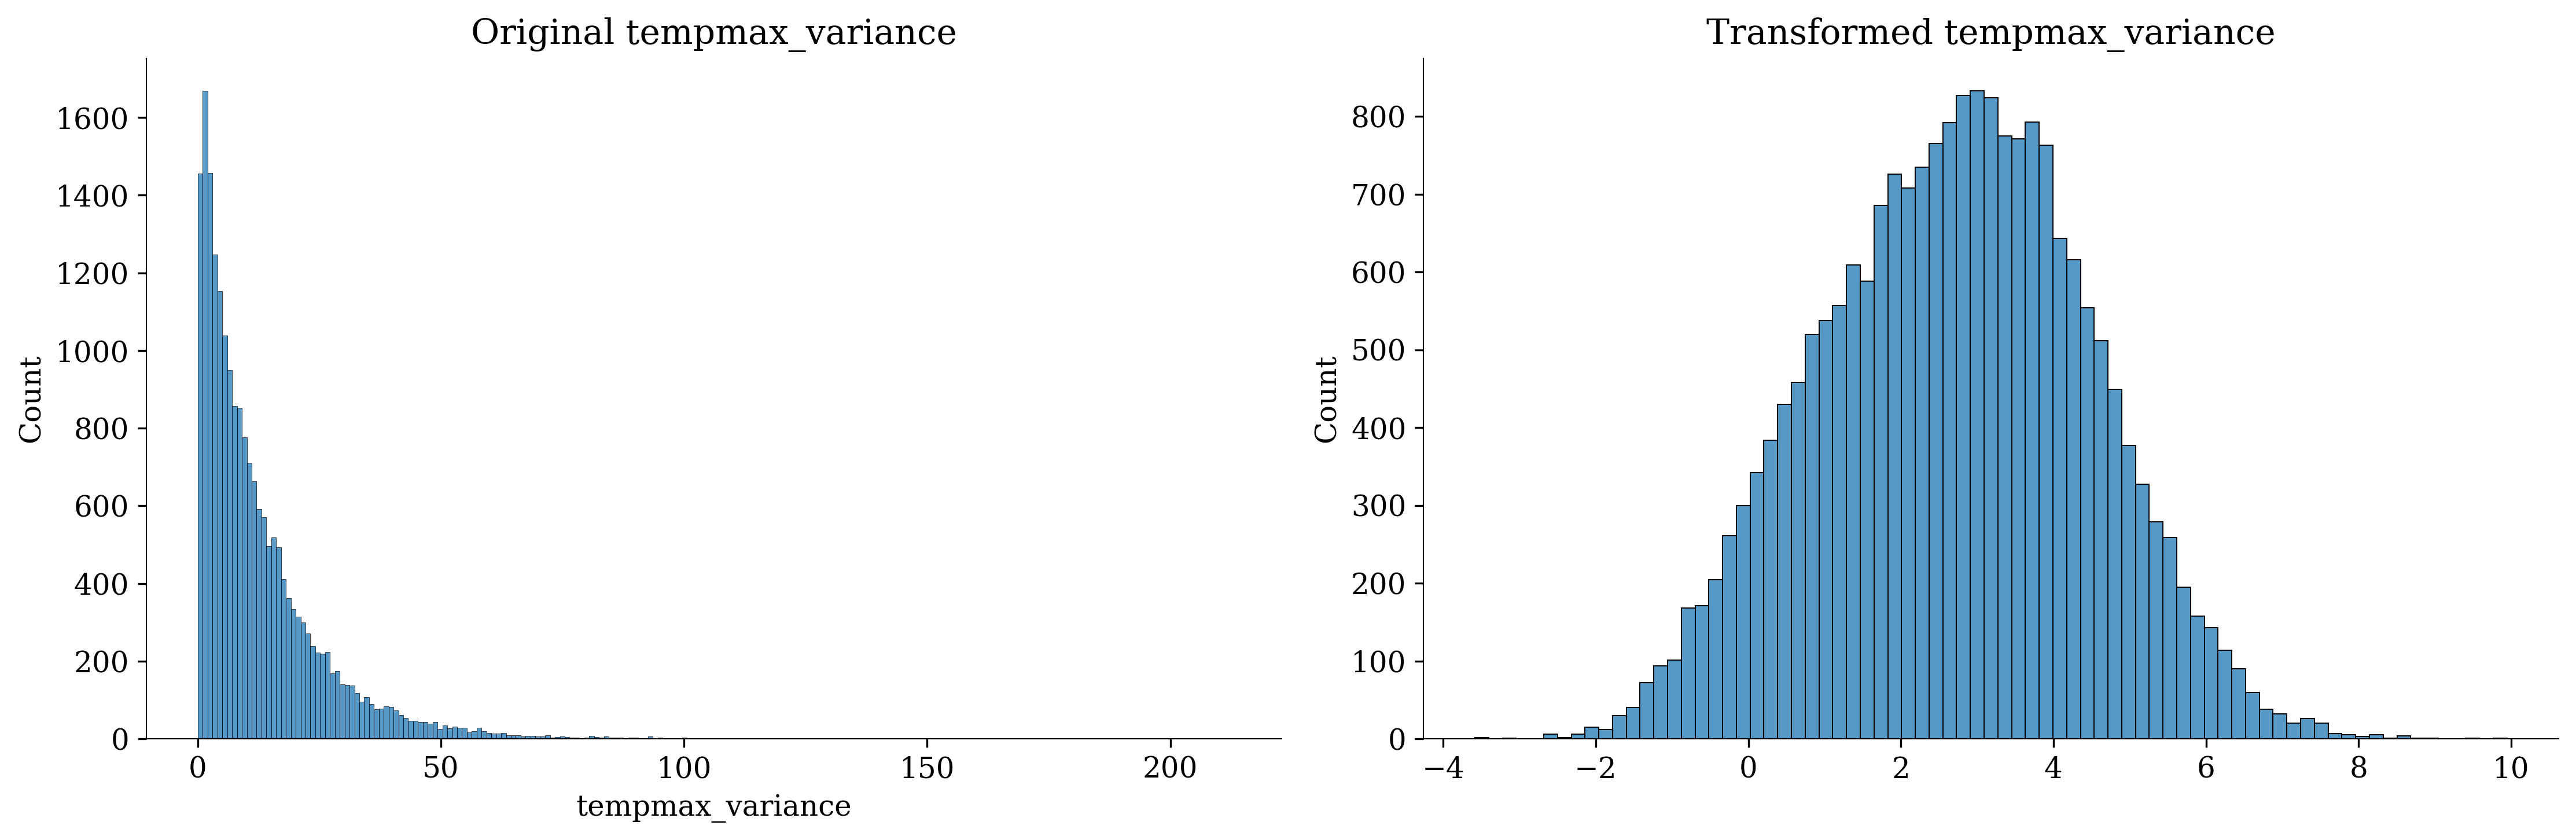

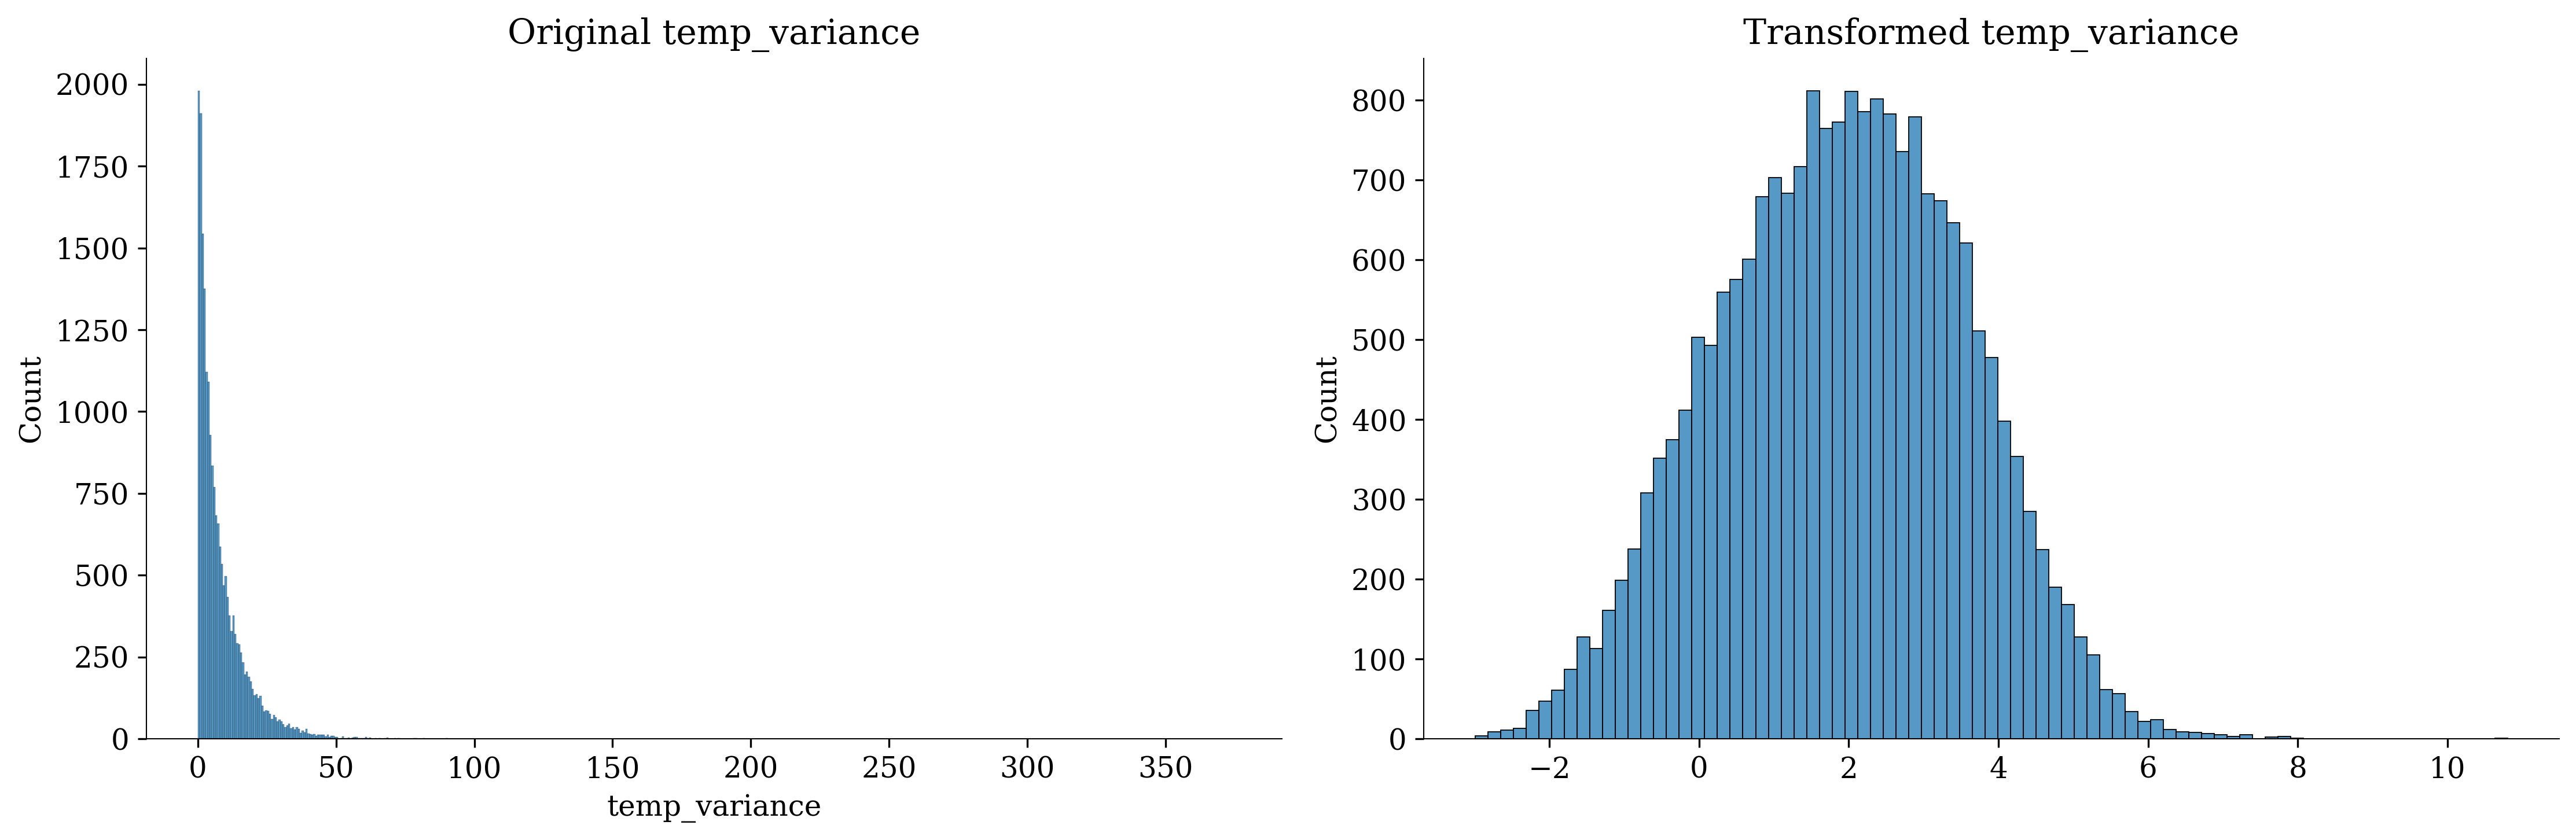

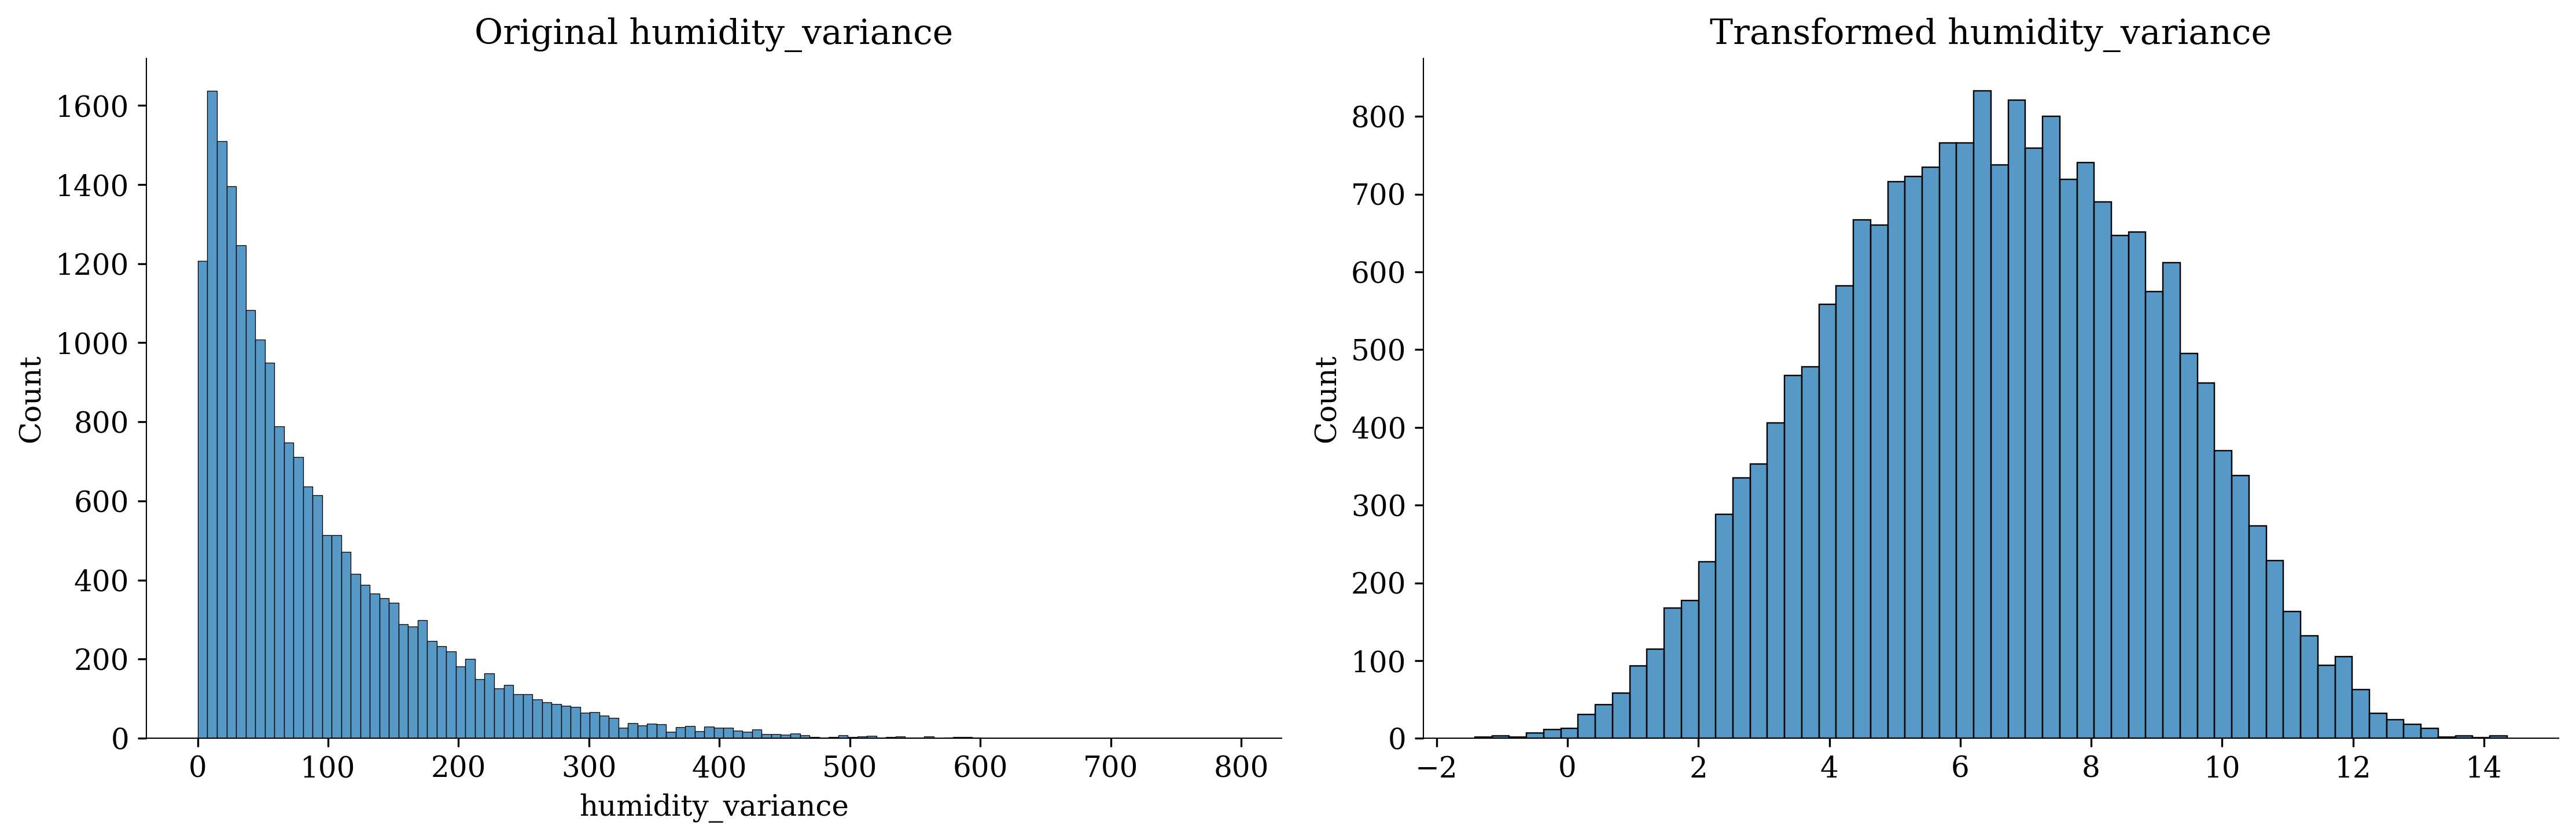

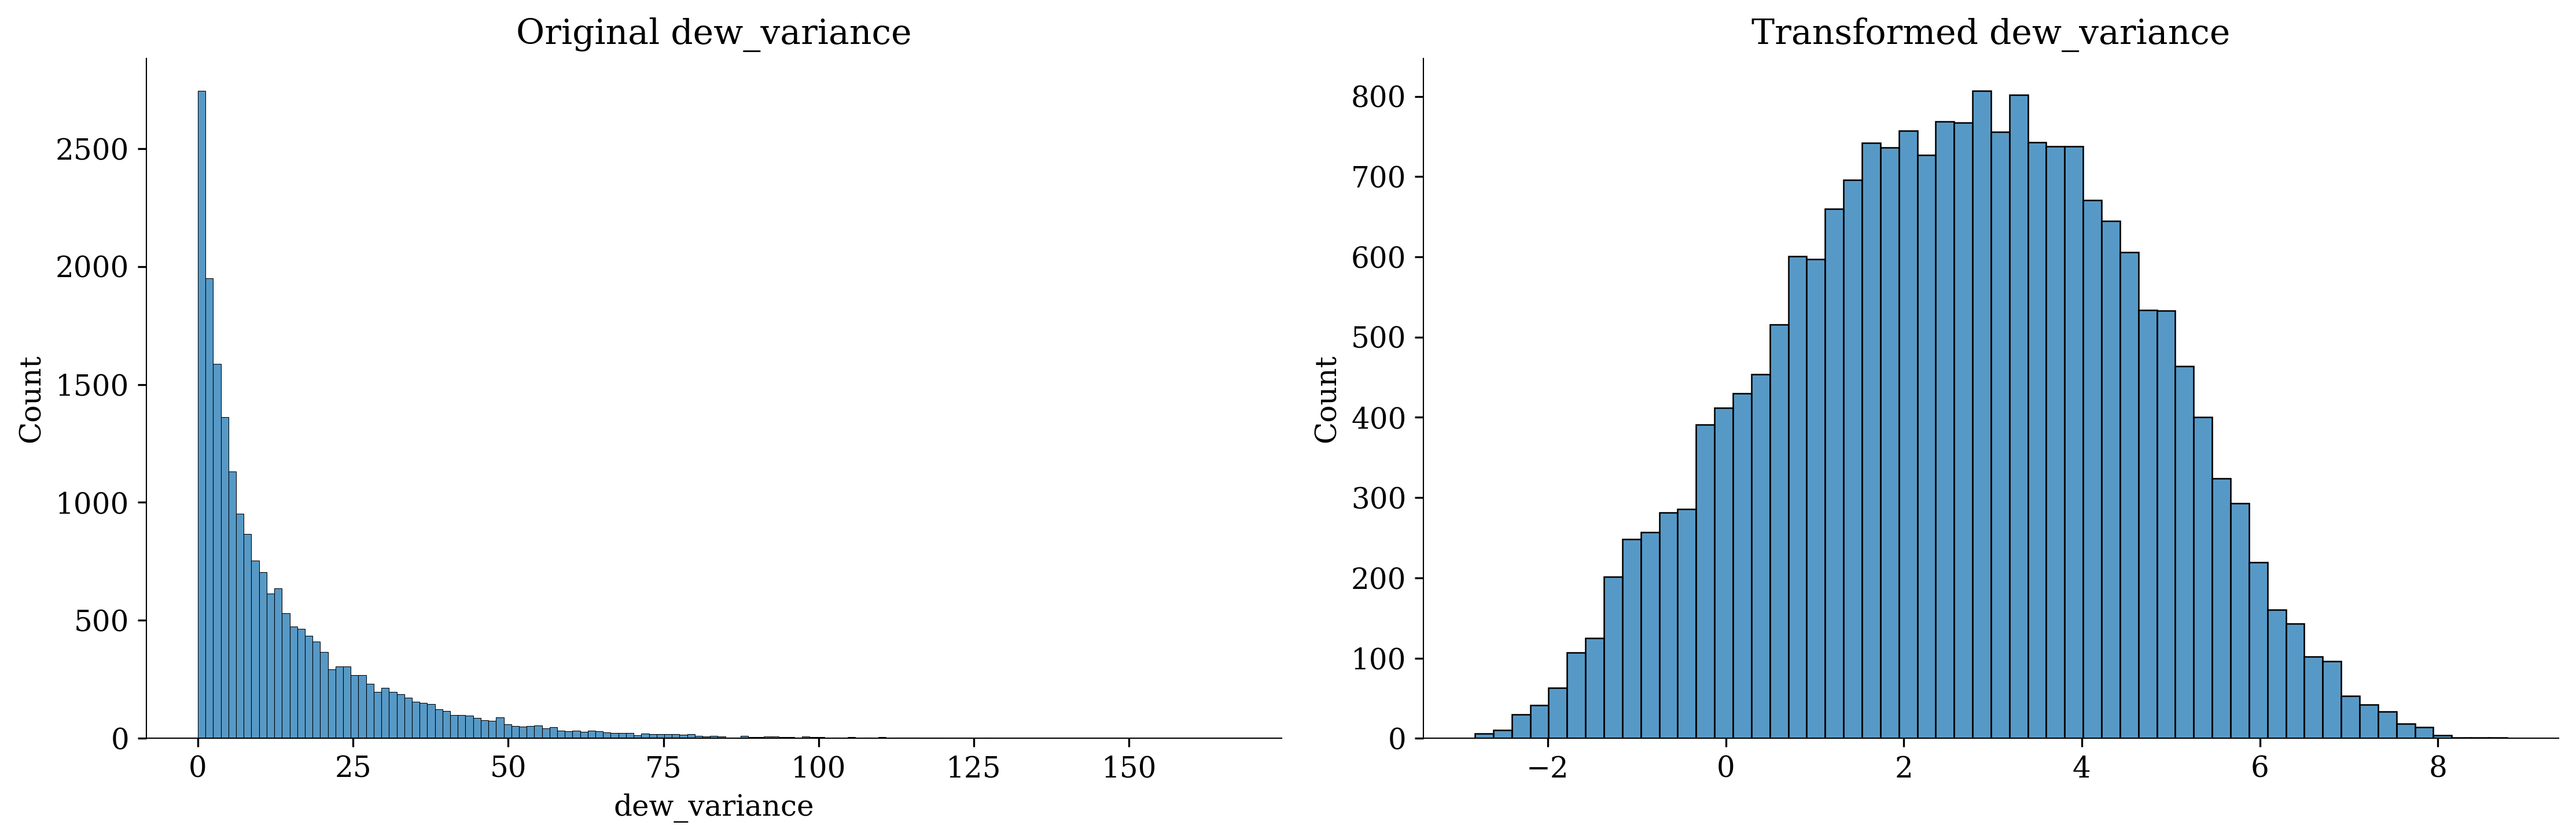

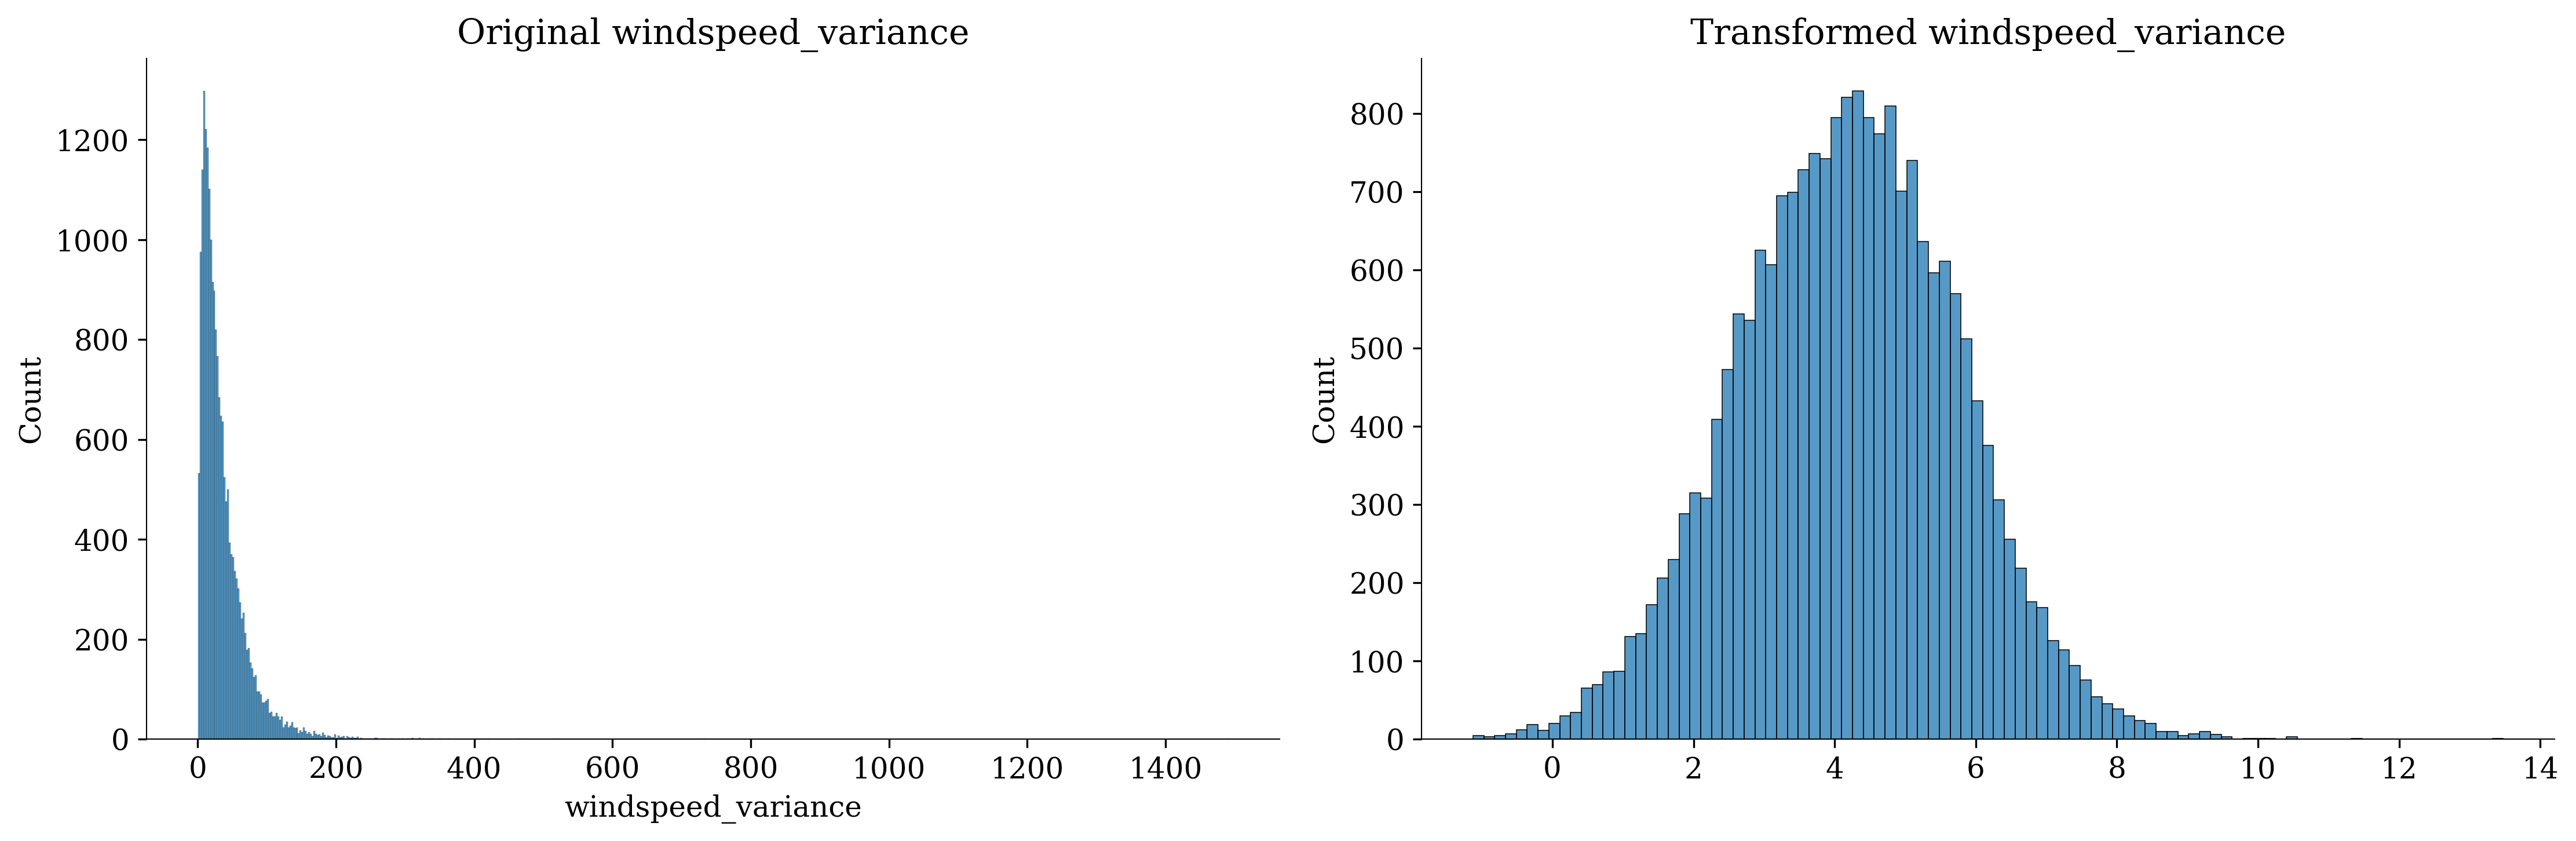

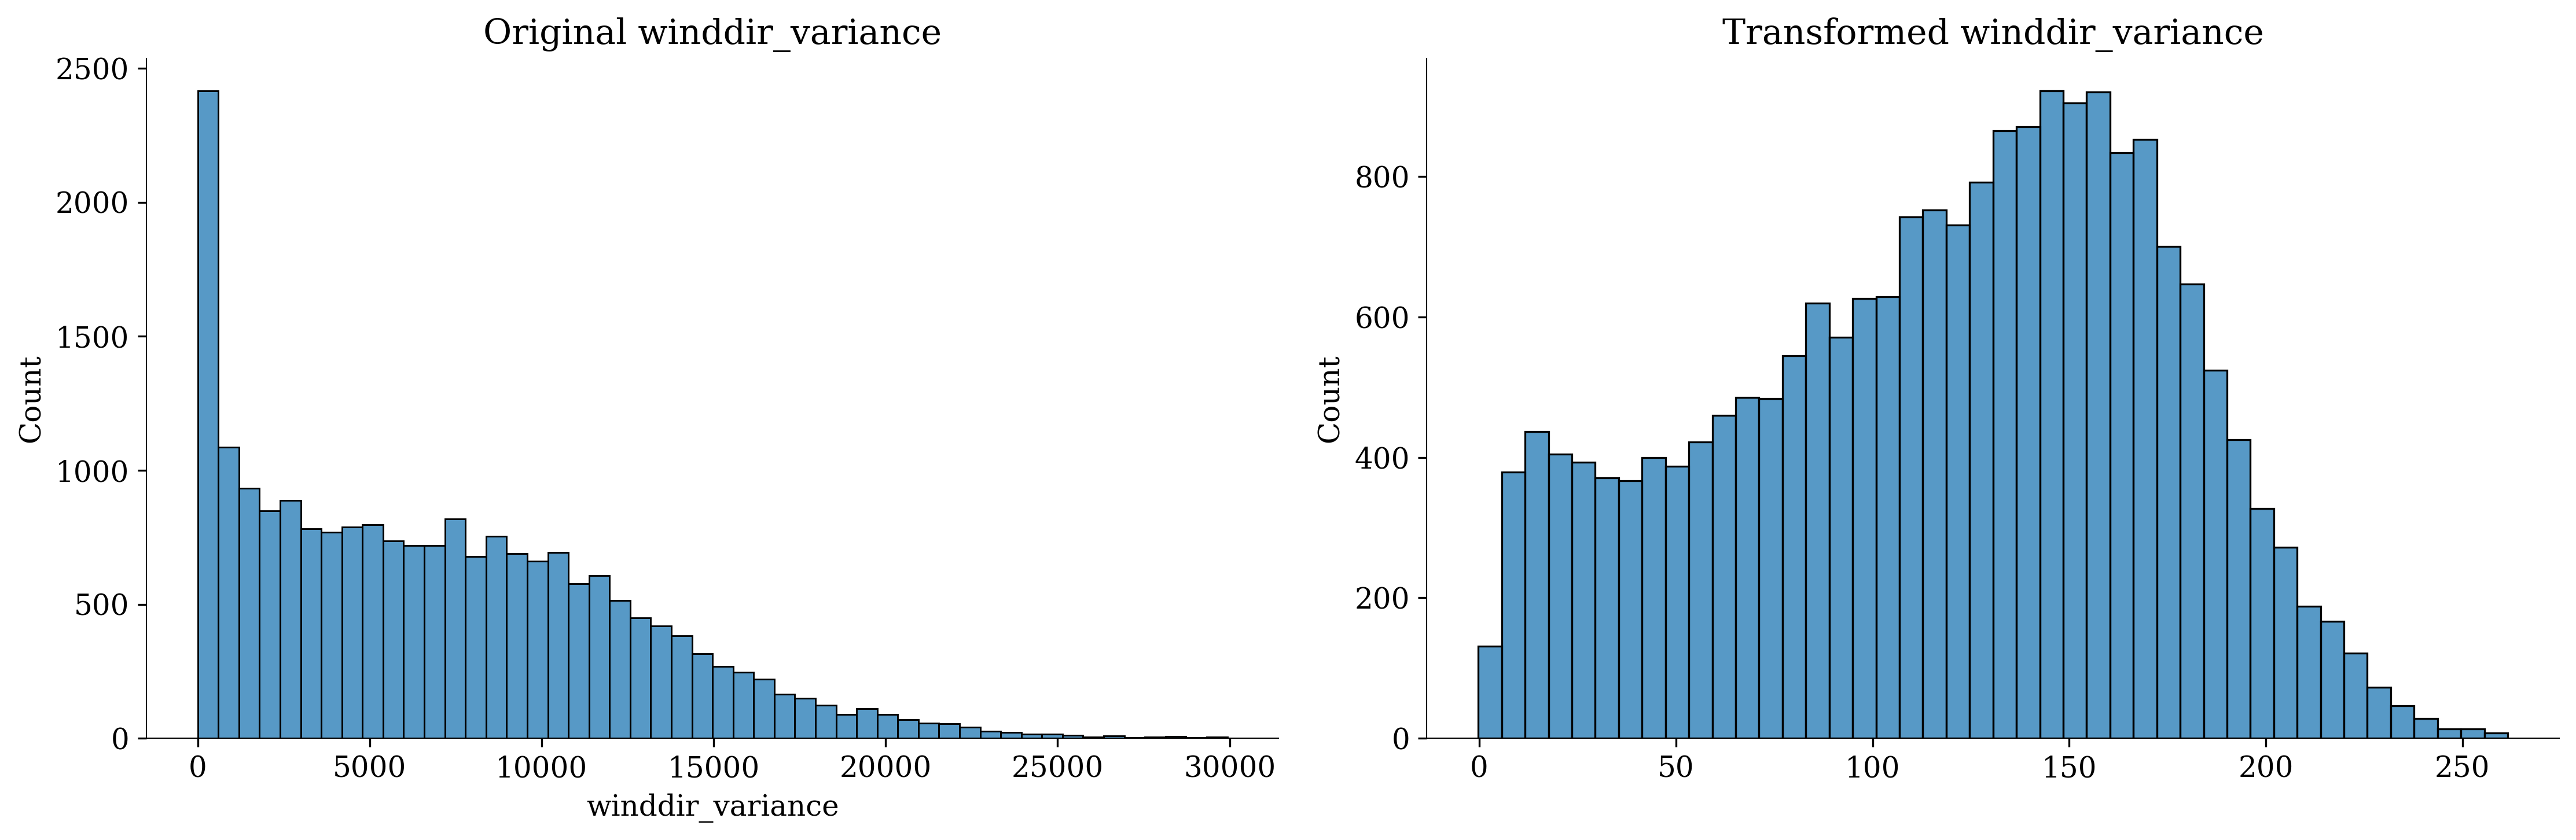

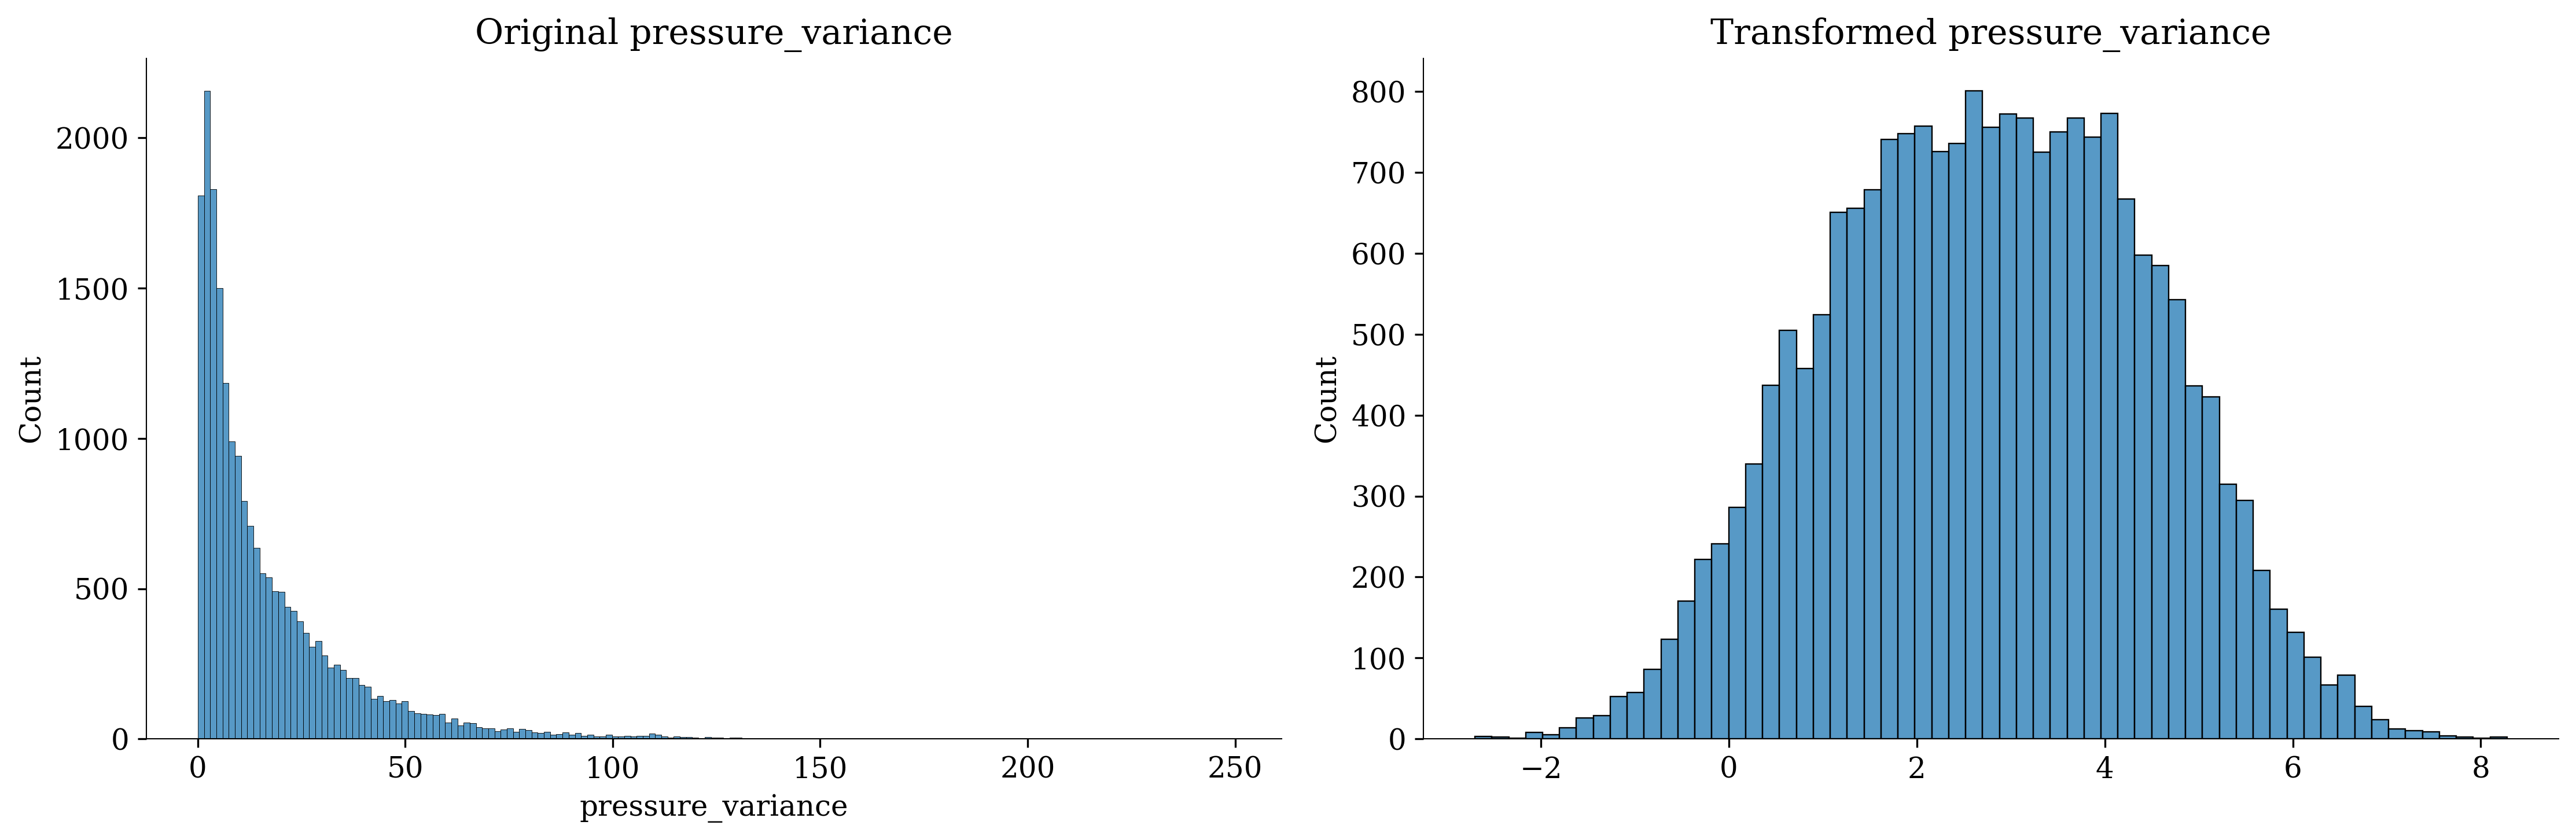

In [83]:
from scipy.stats import boxcox

boxcox_cols.remove('precip_variance')

tmp = numeric_df.copy()

for col in boxcox_cols:
    X = numeric_df[col]
    X = boxcox(X)[0]
    
    # Create subplots
    plt.subplots(1, 2, dpi=300, figsize=(15, 5))
    
    # Plot original
    plt.subplot(1, 2, 1)
    plt.title(f'Original {col}')
    sns.histplot(x=numeric_df[col])
    
    plt.subplot(1, 2, 2)
    plt.title(f'Transformed {col}')
    sns.histplot(x=X)

These are good transformations, we can now change them.

In [84]:
for col in boxcox_cols:
    numeric_df[col] = boxcox(numeric_df[col])[0]

In [85]:
numeric_df.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
2       1992              1       1.00  33.058333  -79.979167    13.700000   
3       1992              2       0.25  40.775000  -74.854160     6.385714   
5       1992              3       1.91  31.018500  -83.297300    14.457143   
6       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  precip_variance  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         0.000000   
2   9.885714     81.428571    4.185714  6.671429  ...        55.589796   
3   1.585714     67.185714    1.394286 -4.242857  ...         9.546510   
5  11.828571     78.957143    4.685714  8.128571  ...        59.321224   
6  10.985714     79.971429    0.188571  7.500000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      1.996879        3.5            5.249817             -1.8   
2         -4.40      2.407602        0.1            1.966009              2.0   
3          0.00      4.046228        4.0            4.703349            -10.6   
5         -9.70      2.767724       -4.1            2.927803              0.2   
6         -1.32      2.947874       -7.9            4.311854              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0         70.421101          -48.6           4.284964            -4.3  
2        192.632581          -14.9           3.640714             2.4  
3        197.472098         -254.6           5.925481            -0.9  
5        198.521705          223.6           3.828579            -8.4  
6        214.161435          -24.8           3.091151            -2.7  

[5 rows x 32 columns]

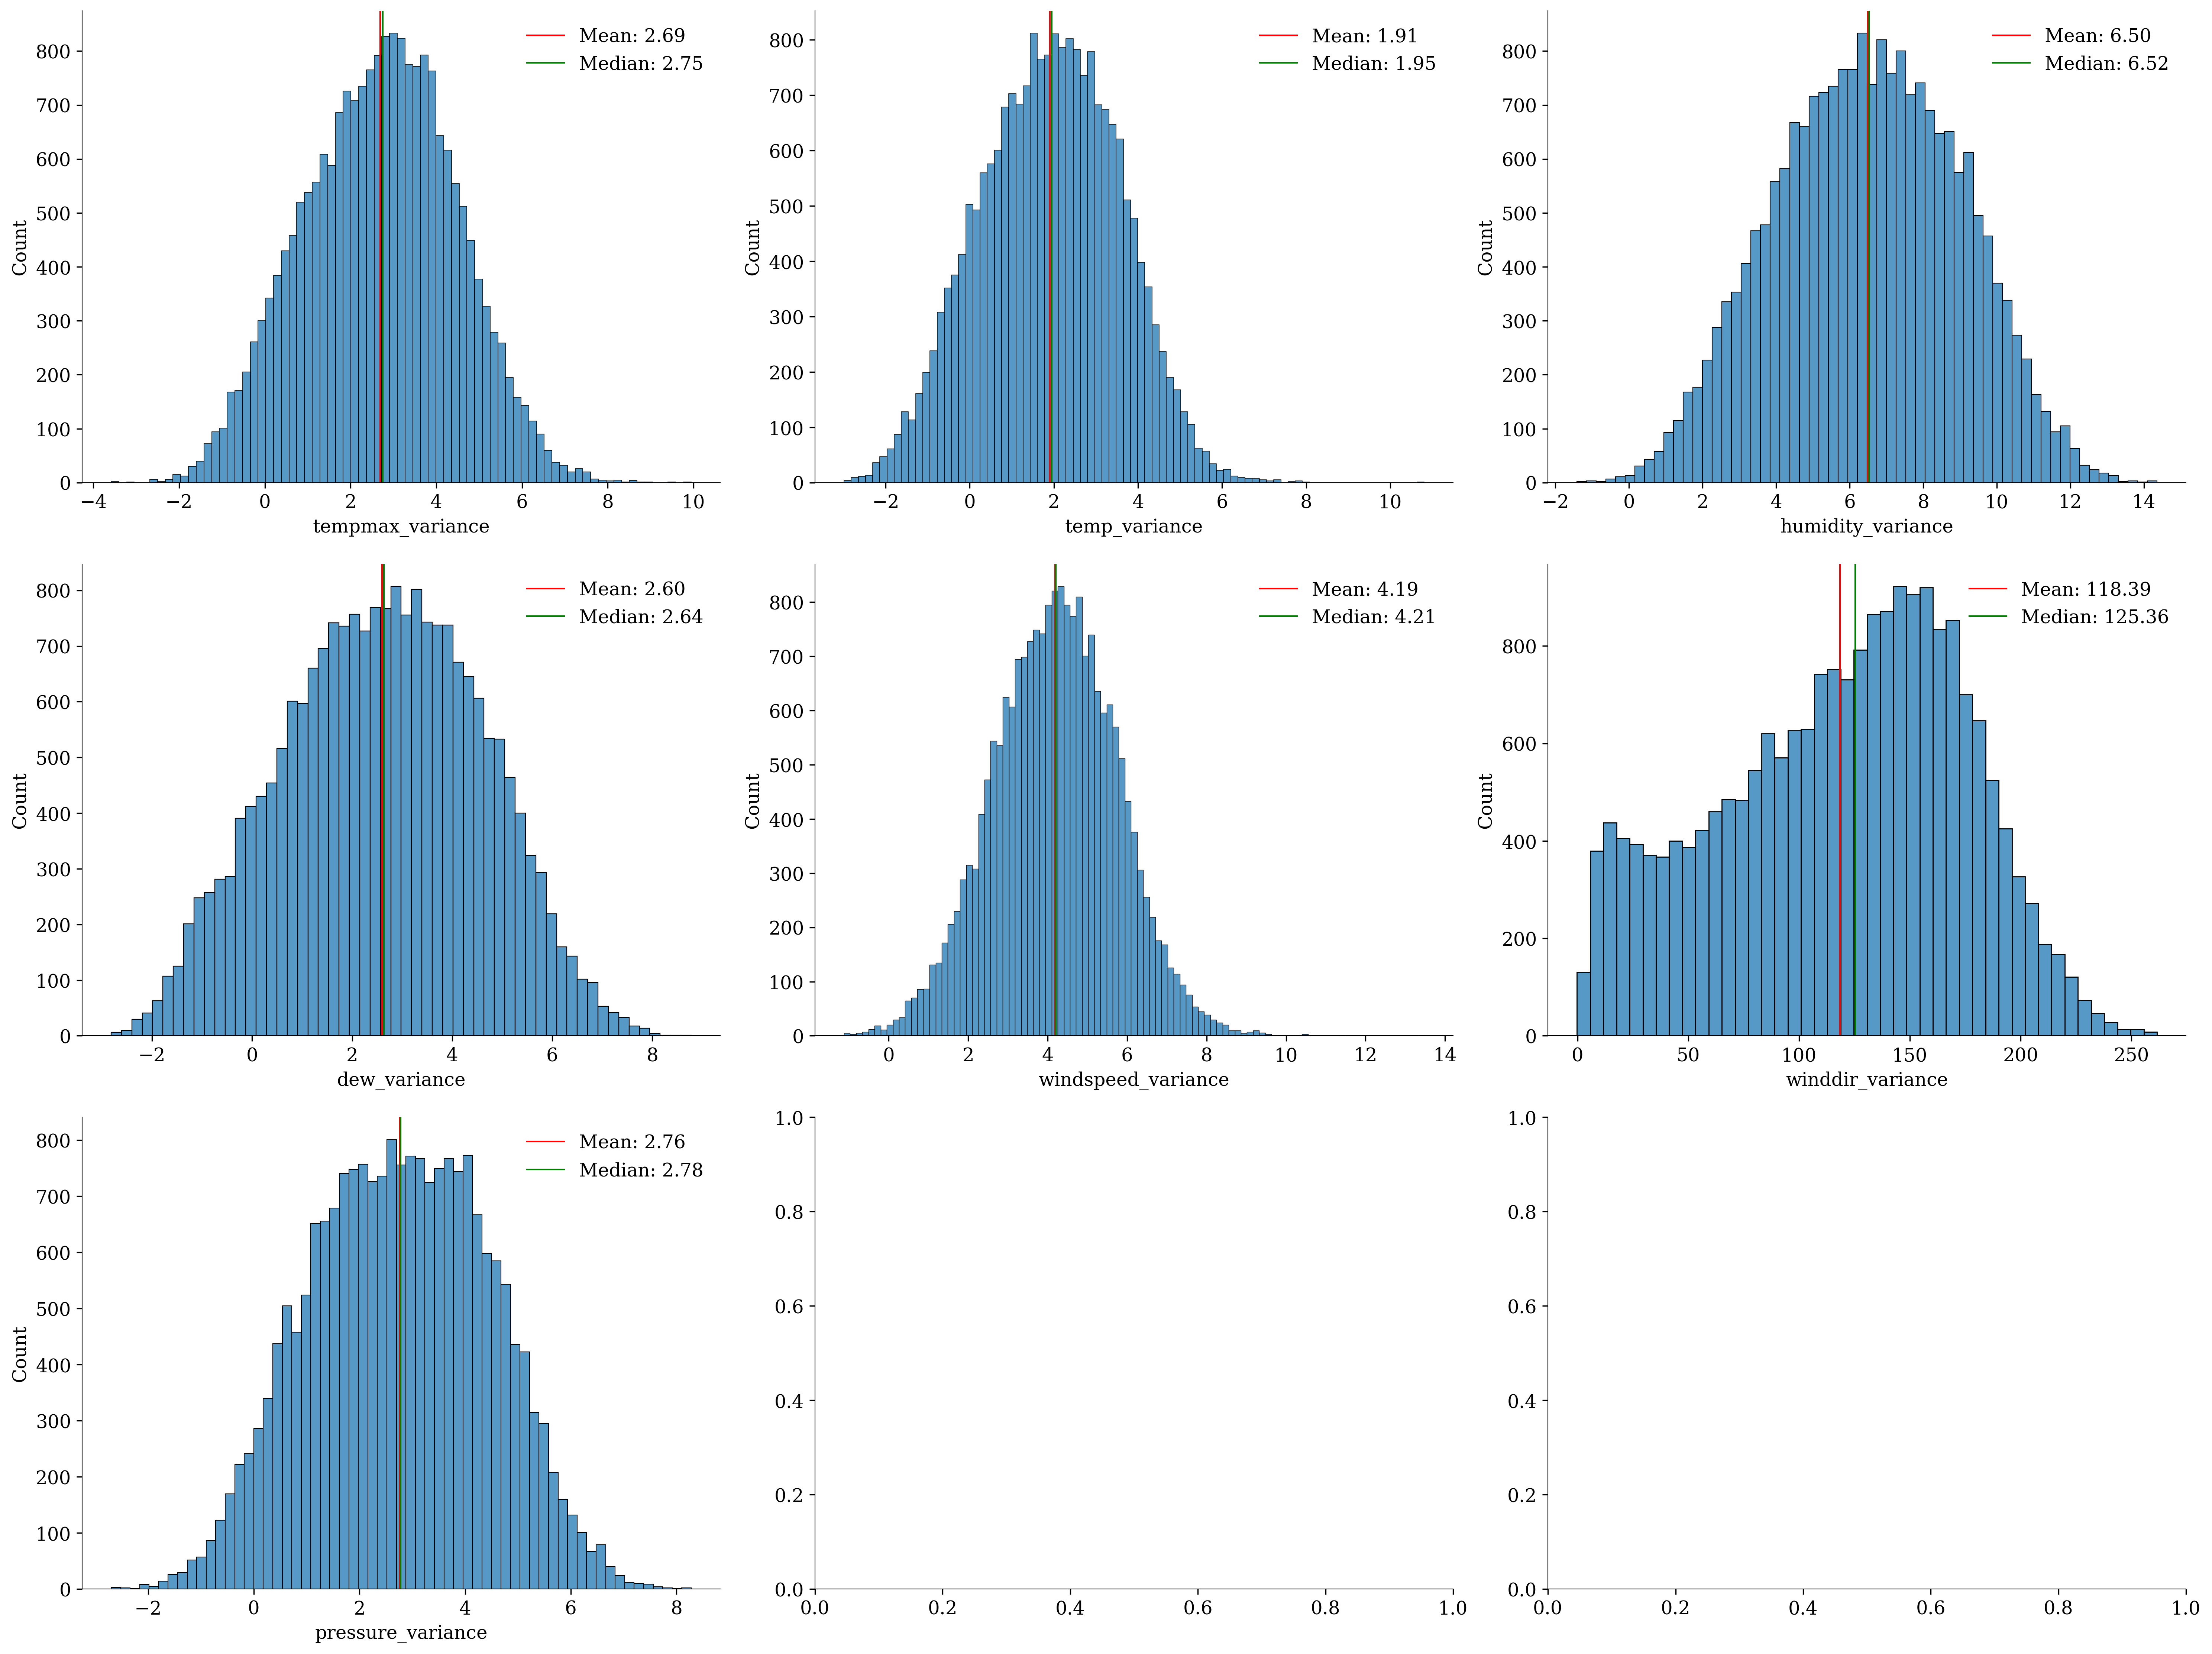

In [87]:
utils.HistogramSubplots(numeric_df[boxcox_cols], figsize=(20, 15))

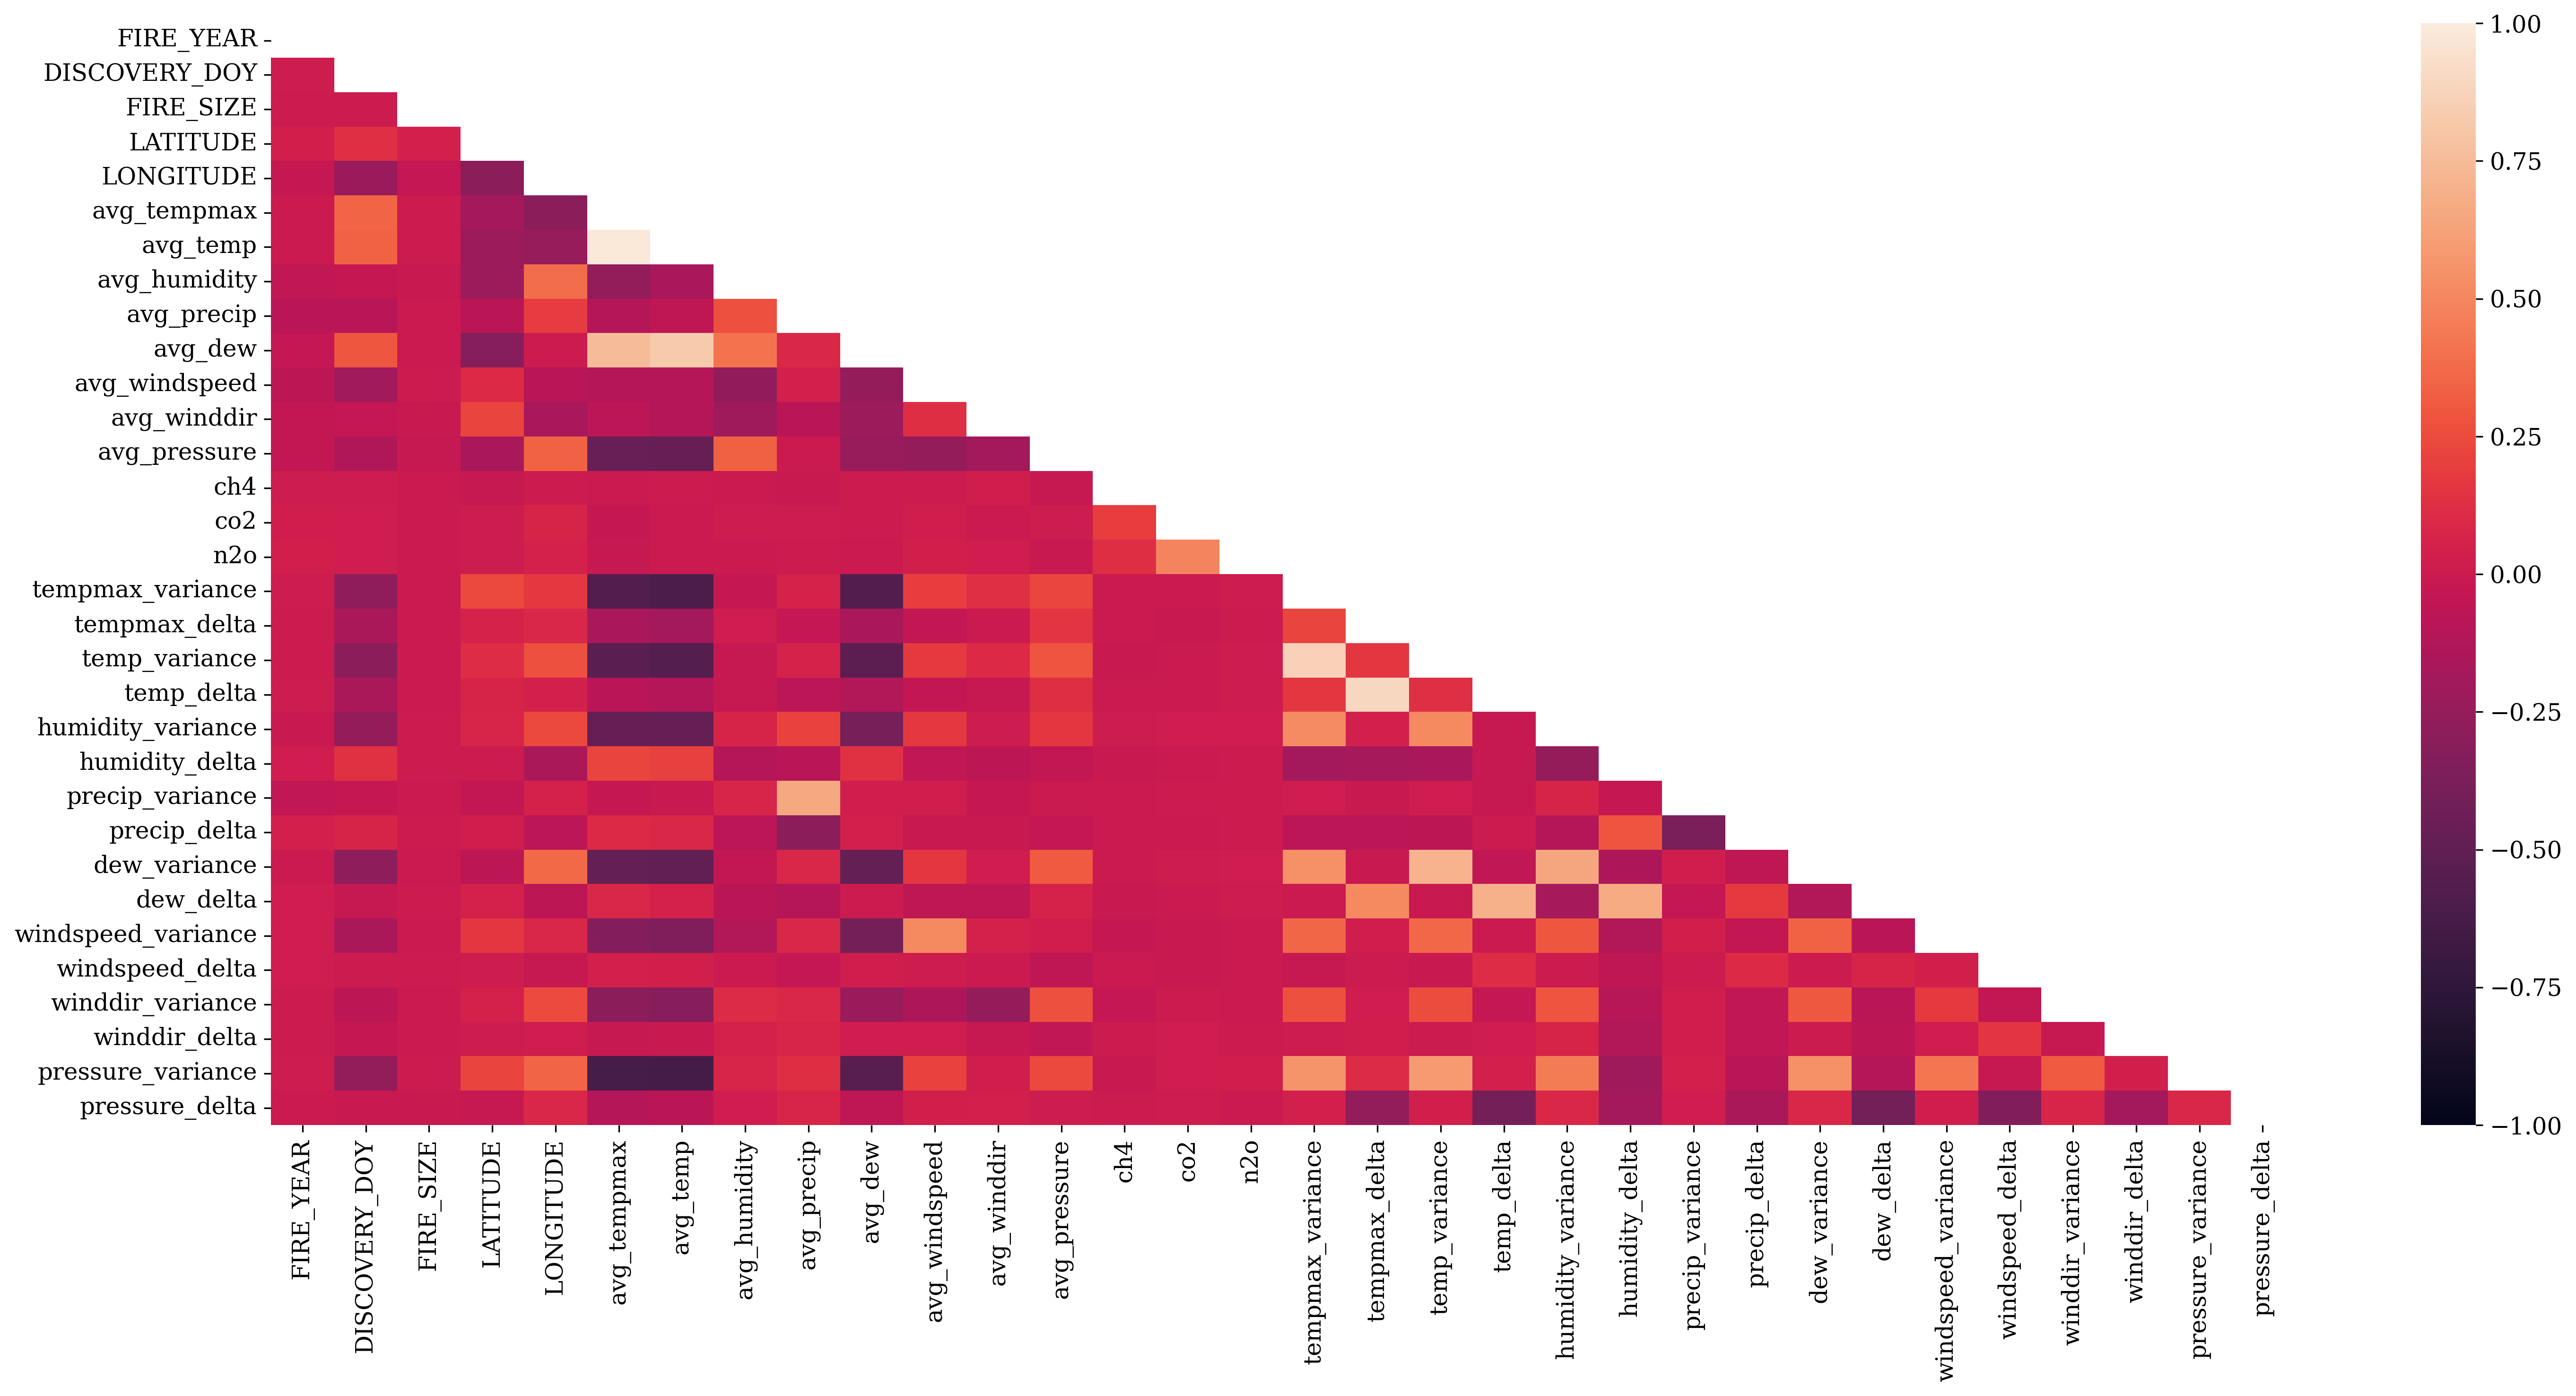

In [90]:
# Plot the correlation using a heatmap
corr = numeric_df.corr()

plt.figure(figsize=(20,10), dpi=300)
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, vmin=-1, vmax=1)
plt.show()

## Linear Regression

### Baseline Linear Regression

In [91]:
df_processed = pd.concat([numeric_df, categorical_df], axis=1)
df_processed.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
2       1992              1       1.00  33.058333  -79.979167    13.700000   
3       1992              2       0.25  40.775000  -74.854160     6.385714   
5       1992              3       1.91  31.018500  -83.297300    14.457143   
6       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  state_SD  state_TN  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         1         0   
2   9.885714     81.428571    4.185714  6.671429  ...         0         0   
3   1.585714     67.185714    1.394286 -4.242857  ...         0         0   
5  11.828571     78.957143    4.685714  8.128571  ...         0         0   
6  10.985714     79.971429    0.188571  7.500000  ...         0         0   

   state_TX  state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  \
0         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
5         0         0         0         0         0         0         0   
6         0         0         0         0         0         0         0   

   state_WY  
0         0  
2         0  
3         0  
5         0  
6         0  

[5 rows x 86 columns]

In [94]:
df_processed.columns

Index(['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE',
       'avg_tempmax', 'avg_temp', 'avg_humidity', 'avg_precip', 'avg_dew',
       'avg_windspeed', 'avg_winddir', 'avg_pressure', 'ch4', 'co2', 'n2o',
       'tempmax_variance', 'tempmax_delta', 'temp_variance', 'temp_delta',
       'humidity_variance', 'humidity_delta', 'precip_variance',
       'precip_delta', 'dew_variance', 'dew_delta', 'windspeed_variance',
       'windspeed_delta', 'winddir_variance', 'winddir_delta',
       'pressure_variance', 'pressure_delta', 'FIRE_SIZE_CLASS',
       'FIRE_SIZE_NUMERIC', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NH

In [129]:
from sklearn.model_selection import train_test_split

X = df_processed.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_SIZE_NUMERIC'], axis=1)
y = df_processed['FIRE_SIZE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [130]:
robust_cols = ['precip_variance', 'ch4', 'n2o', 'co2']
minmax_cols = ['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']
state_cols = [col for col in X_train.columns
              if 'state' in col]
ss_cols = [col for col in X_train.columns
           if col not in robust_cols
           if col not in minmax_cols
           if col not in state_cols]

In [131]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Create column transformation list
col_transforms = [('standard scale', StandardScaler(), ss_cols),
                  ('minmax scale', MinMaxScaler(), minmax_cols), 
                  ('robust scale', RobustScaler(), robust_cols)]

# Create the column transformer
col_transformer = ColumnTransformer(col_transforms, remainder='passthrough')

# Fit to X_train
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standard scale', StandardScaler(),
                                 ['avg_tempmax', 'avg_temp', 'avg_humidity',
                                  'avg_precip', 'avg_dew', 'avg_windspeed',
                                  'avg_winddir', 'avg_pressure',
                                  'tempmax_variance', 'tempmax_delta',
                                  'temp_variance', 'temp_delta',
                                  'humidity_variance', 'humidity_delta',
                                  'precip_delta', 'dew_variance', 'dew_delta',
                                  'windspeed_variance', 'windspeed_delta',
                                  'winddir_variance', 'winddir_delta',
                                  'pressure_variance', 'pressure_delta']),
                                ('minmax scale', MinMaxScaler(),
                                 ['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE',
                    

In [132]:
X_train_transformed = col_transformer.transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

In [133]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_transformed, y_train);

Now that we have created a model we are able to make some predictions on our validation set.

In [134]:
print(f'Test score: {linreg.score(X_test_transformed, y_test)}')

Test score: -0.8178369962090901


### Baseline Model Evaluation

Looking at the coefficients:

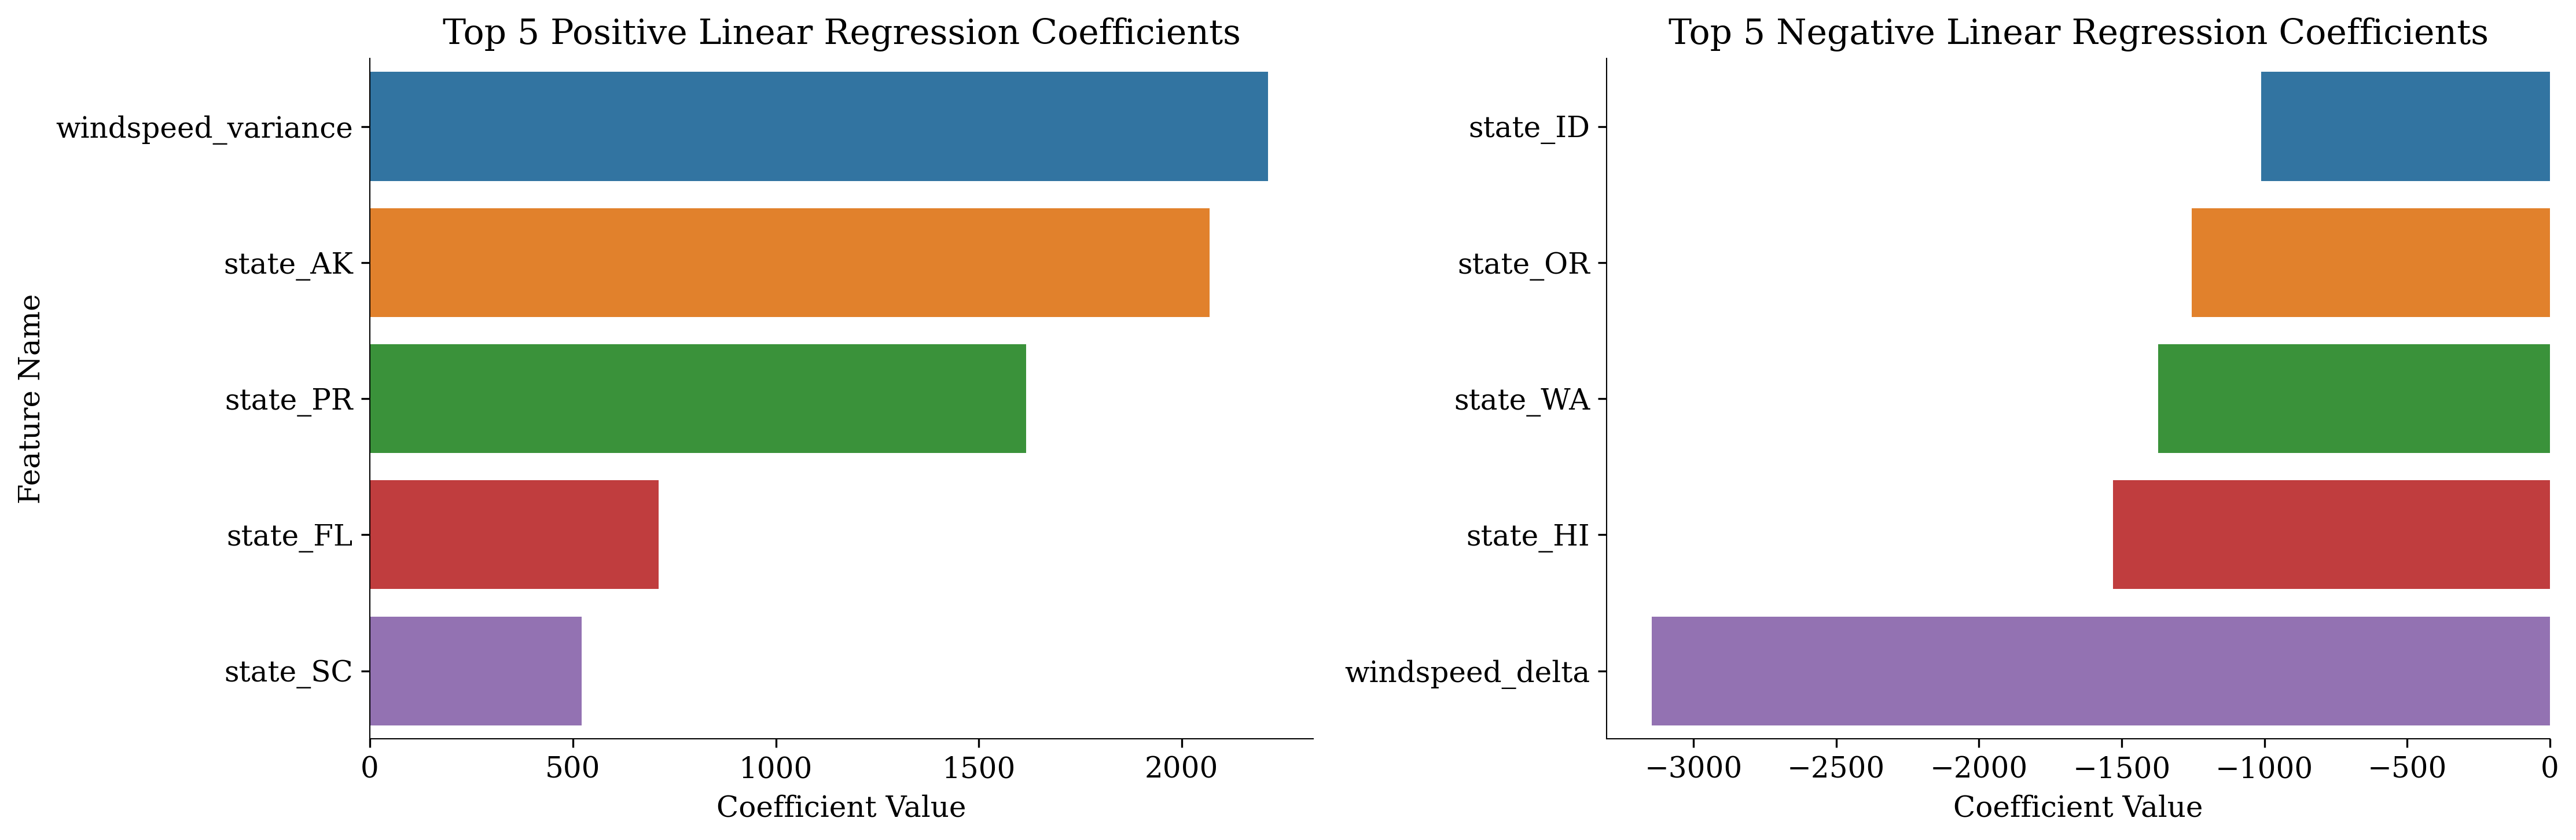

In [135]:
# The intercept
intercept = linreg.intercept_

# The coefficient, notice it returns an array with one spot for each feature
coefficients = linreg.coef_

coefficients_df = pd.DataFrame(data={'coef':coefficients}, index=X.columns).sort_values(by='coef', ascending=False)

plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Top 5 Positive Linear Regression Coefficients')
sns.barplot(x='coef', y=coefficients_df.head().index, data=coefficients_df.head())
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')

plt.subplot(1, 2, 2)
plt.title('Top 5 Negative Linear Regression Coefficients')
sns.barplot(x='coef', y=coefficients_df.tail().index, data=coefficients_df.tail())
plt.xlabel('Coefficient Value')
plt.show()

Calculating the Mean Absolute Error (MAE)

In [136]:
from sklearn.metrics import mean_absolute_error

y_pred = linreg.predict(X_test_transformed)

mean_absolute_error(y_test, y_pred)

179.87799881850805

Calculating the Root Mean Squared Error (RMSE)

In [137]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

449156.1170515191

### Model Improvement

Using Ridge and Lasso regression

In [162]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score

alphas = np.linspace(1, 20, 10)

cross_val_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    cv_score = np.mean(cross_val_score(lasso, X_train, y_train, cv = 5))
    cross_val_scores.append(cv_score)

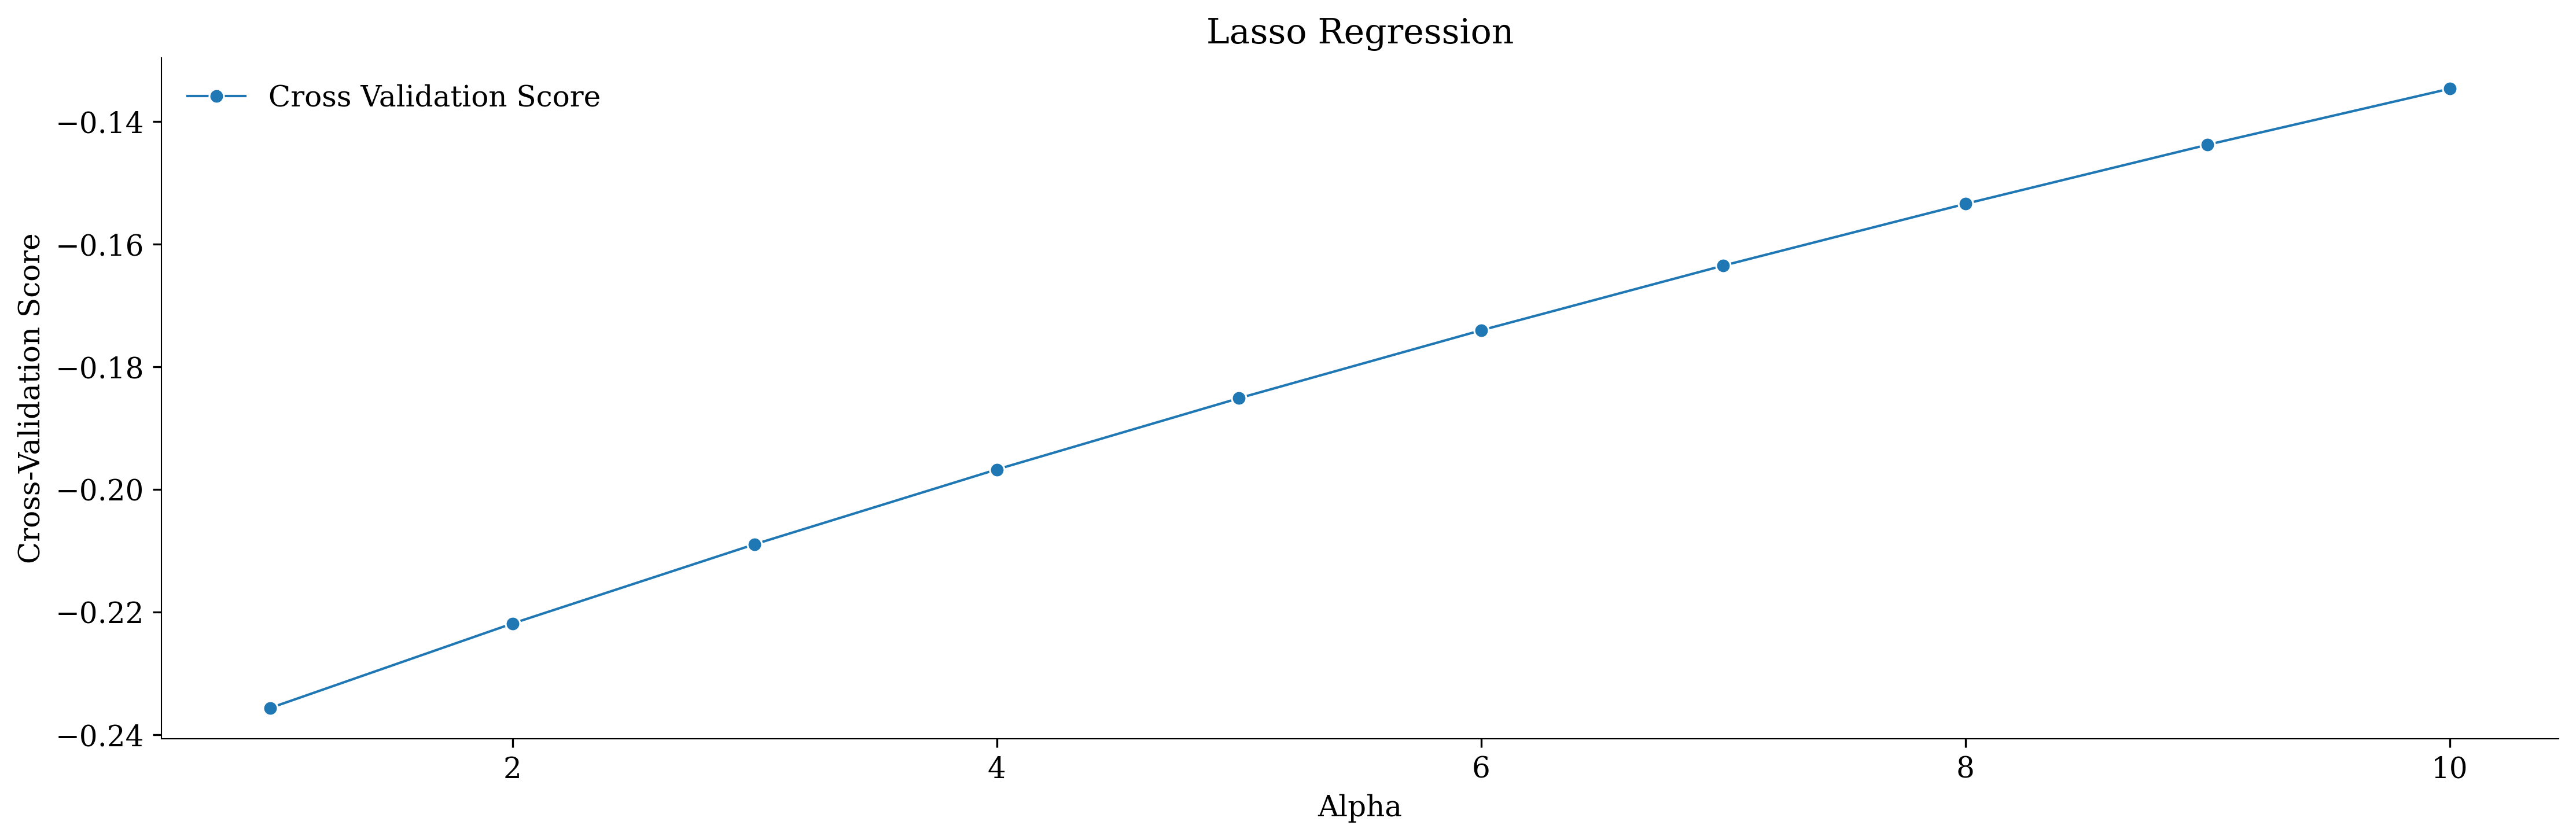

In [170]:
plt.figure(figsize=(15, 5), dpi=300)
plt.title('Lasso Regression')
sns.lineplot(x=alphas, y=cross_val_scores, marker='o', label='Cross Validation Score')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Score')
plt.show()

In [181]:
reload(model_utils);

In [182]:
lasso_df = model_utils.ridge_lasso_evaluation(Lasso, X_train, y_train, alphas)
display(lasso_df)

Alpha = 1.0  Alpha = 2.0  Alpha = 3.0  Alpha = 4.0  \
FIRE_YEAR         1.053948     0.924529     0.782814     0.659048   
DISCOVERY_DOY    -0.237612    -0.259591    -0.280663    -0.302529   
LATITUDE         12.377211    11.378459    12.117799    12.782091   
LONGITUDE        -0.912548    -0.632032    -0.917489    -1.188448   
avg_tempmax      11.083733    10.555375     9.154343     6.870118   
...                    ...          ...          ...          ...   
state_VT         -0.000000    -0.000000    -0.000000    -0.000000   
state_WA        -94.571227   -23.759128    -0.000000    -0.000000   
state_WI         -6.179064    -0.000000    -0.000000    -0.000000   
state_WV          0.000000     0.000000     0.000000     0.000000   
state_WY         -0.000000    -0.000000    -0.000000    -0.000000   

               Alpha = 5.0  Alpha = 6.0  Alpha = 7.0  Alpha = 8.0  \
FIRE_YEAR         0.580376     0.509186     0.438055     0.370631   
DISCOVERY_DOY    -0.322914    -0.342954    -0.362996    -0.382882   
LATITUDE         13.544629    14.381848    15.219328    16.116276   
LONGITUDE        -1.474511    -1.734470    -1.993653    -2.214927   
avg_tempmax       5.561135     5.620741     5.707419     5.666980   
...                    ...          ...          ...          ...   
state_VT         -0.000000    -0.000000    -0.000000    -0.000000   
state_WA         -0.000000    -0.000000    -0.000000    -0.000000   
state_WI         -0.000000    -0.000000    -0.000000    -0.000000   
state_WV          0.000000     0.000000     0.000000     0.000000   
state_WY         -0.000000    -0.000000    -0.000000    -0.000000   

               Alpha = 9.0  Alpha = 10.0  
FIRE_YEAR         0.294637      0.227421  
DISCOVERY_DOY    -0.401648     -0.420405  
LATITUDE         17.012509     17.970958  
LONGITUDE        -2.424230     -2.668439  
avg_tempmax       4.928177      3.719336  
...                    ...           ...  
state_VT         -0.000000     -0.000000  
state_WA         -0.000000     -0.000000  
state_WI         -0.000000     -0.000000  
state_WV          0.000000      0.000000  
state_WY         -0.000000     -0.000000  

[83 rows x 10 columns]

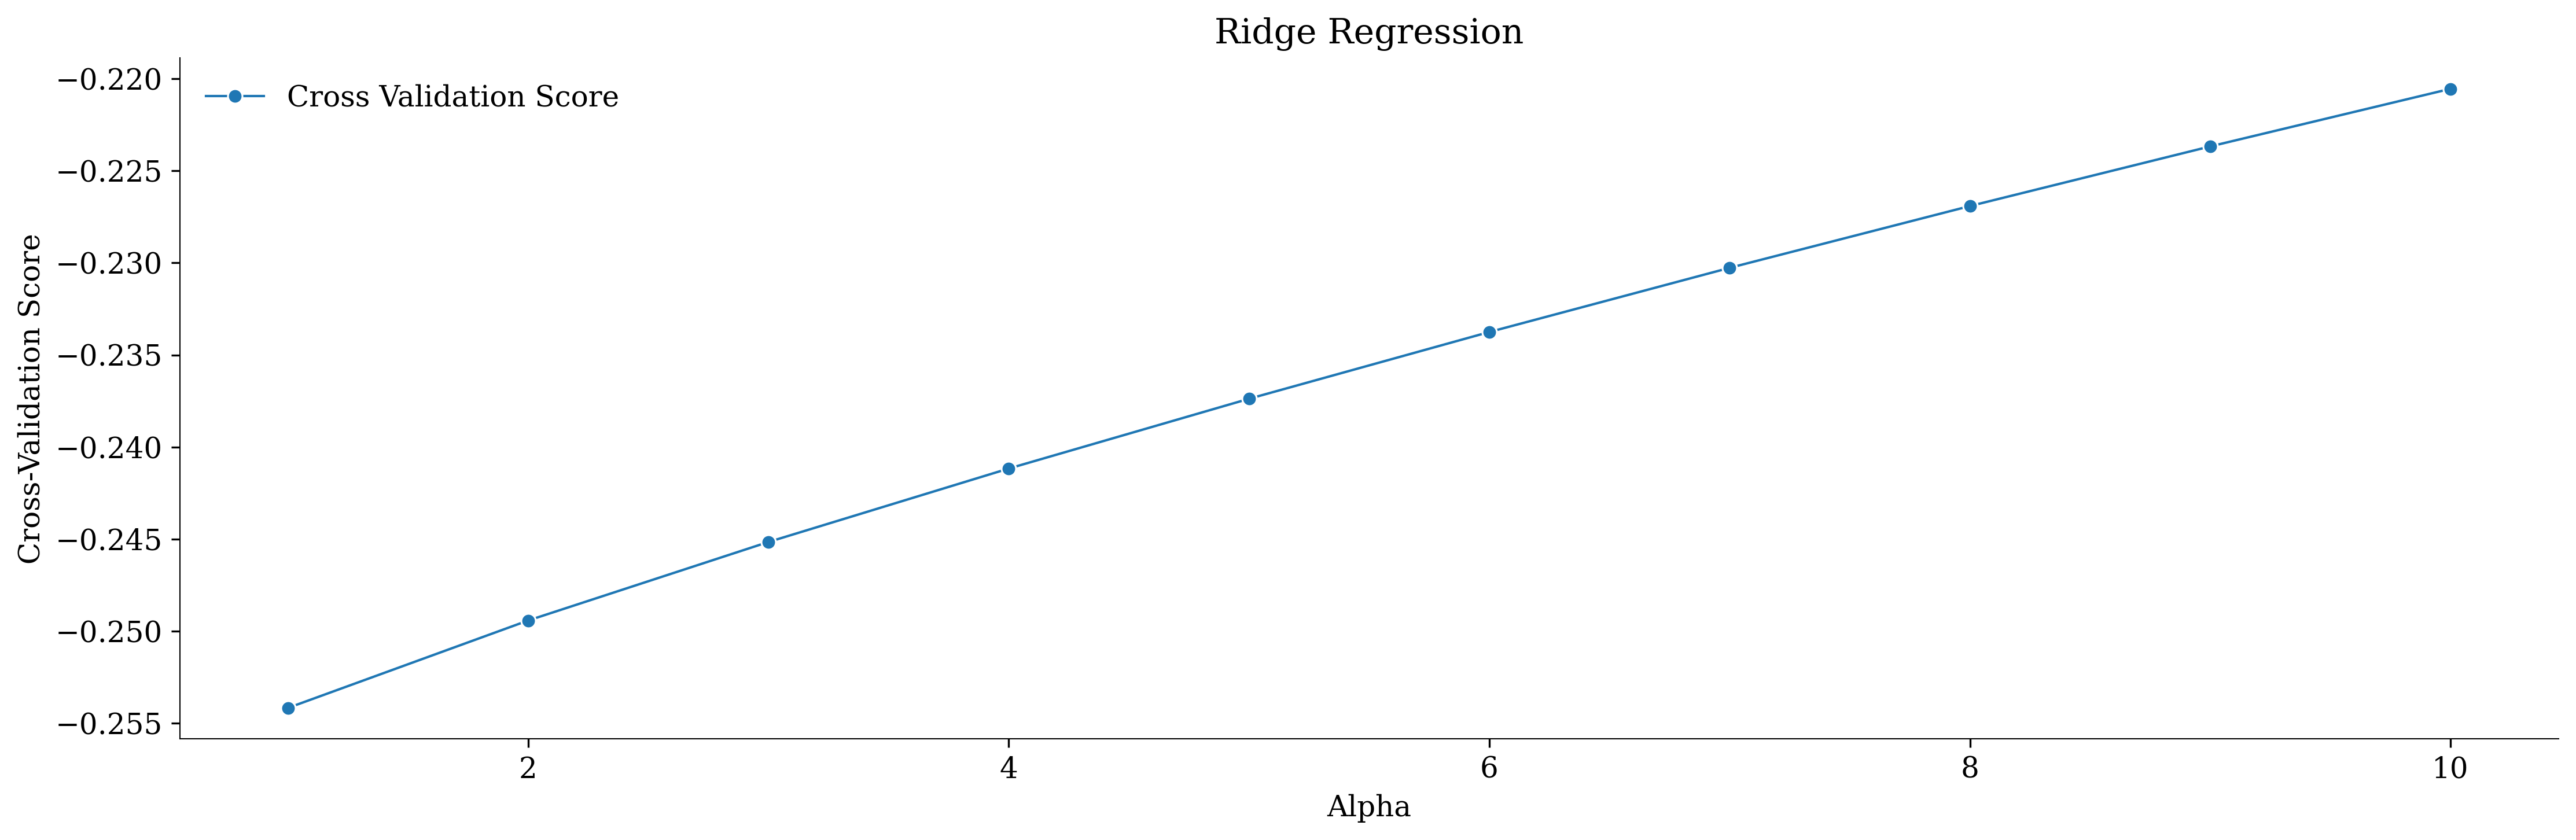

In [171]:
cross_val_scores = []

for alpha in alphas:
    lasso = Ridge(alpha=alpha)
    cv_score = np.mean(cross_val_score(lasso, X_train, y_train, cv = 5))
    cross_val_scores.append(cv_score)
    
plt.figure(figsize=(15, 5), dpi=300)
plt.title('Ridge Regression')
sns.lineplot(x=alphas, y=cross_val_scores, marker='o', label='Cross Validation Score')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Score')
plt.show()

We see that in this case, because the features are never fully removed, we have a generally less accurate model.

In [185]:
ridge_df = model_utils.ridge_lasso_evaluation(Ridge, X_train, y_train, alphas)
display(ridge_df)

Alpha = 1.0  Alpha = 2.0  Alpha = 3.0  Alpha = 4.0  \
FIRE_YEAR         0.922639     0.947324     0.960355     0.967559   
DISCOVERY_DOY    -0.170709    -0.175537    -0.180241    -0.184835   
LATITUDE         47.546266    48.661515    49.258409    49.608382   
LONGITUDE       -26.035055   -22.652840   -20.598850   -19.211651   
avg_tempmax      11.177657    10.948823    10.685140    10.406990   
...                    ...          ...          ...          ...   
state_VT        202.802586   120.609615    77.993774    53.174951   
state_WA      -1198.048944 -1109.460709 -1054.535107 -1016.421863   
state_WI       -257.026040  -270.698720  -278.779502  -283.911428   
state_WV        304.643263   265.383817   240.466008   222.986871   
state_WY       -719.977206  -666.010059  -631.065849  -605.589611   

               Alpha = 5.0  Alpha = 6.0  Alpha = 7.0  Alpha = 8.0  \
FIRE_YEAR         0.971434     0.973231     0.973651     0.973113   
DISCOVERY_DOY    -0.189328    -0.193726    -0.198033    -0.202253   
LATITUDE         49.824295    49.960904    50.047651    50.101574   
LONGITUDE       -18.208092   -17.446051   -16.846150   -16.360490   
avg_tempmax      10.123174     9.838091     9.554151     9.272754   
...                    ...          ...          ...          ...   
state_VT         37.544634    27.128420    19.883112    14.671396   
state_WA       -987.976514  -965.628788  -947.388216  -932.054028   
state_WI       -287.307126  -289.597546  -291.142649  -292.162476   
state_WV        209.888229   199.600378   191.231473   184.235684   
state_WY       -585.572337  -569.023585  -554.838362  -542.351767   

               Alpha = 9.0  Alpha = 10.0  
FIRE_YEAR         0.971886      0.970150  
DISCOVERY_DOY    -0.206390     -0.210448  
LATITUDE         50.133099     50.148890  
LONGITUDE       -15.958419    -15.619390  
avg_tempmax       8.994743      8.720631  
...                    ...           ...  
state_VT         10.820052      7.910504  
state_WA       -918.857224   -907.281635  
state_WI       -292.798940   -293.147565  
state_WV        178.259395    173.062982  
state_WY       -531.138432   -520.912727  

[83 rows x 10 columns]

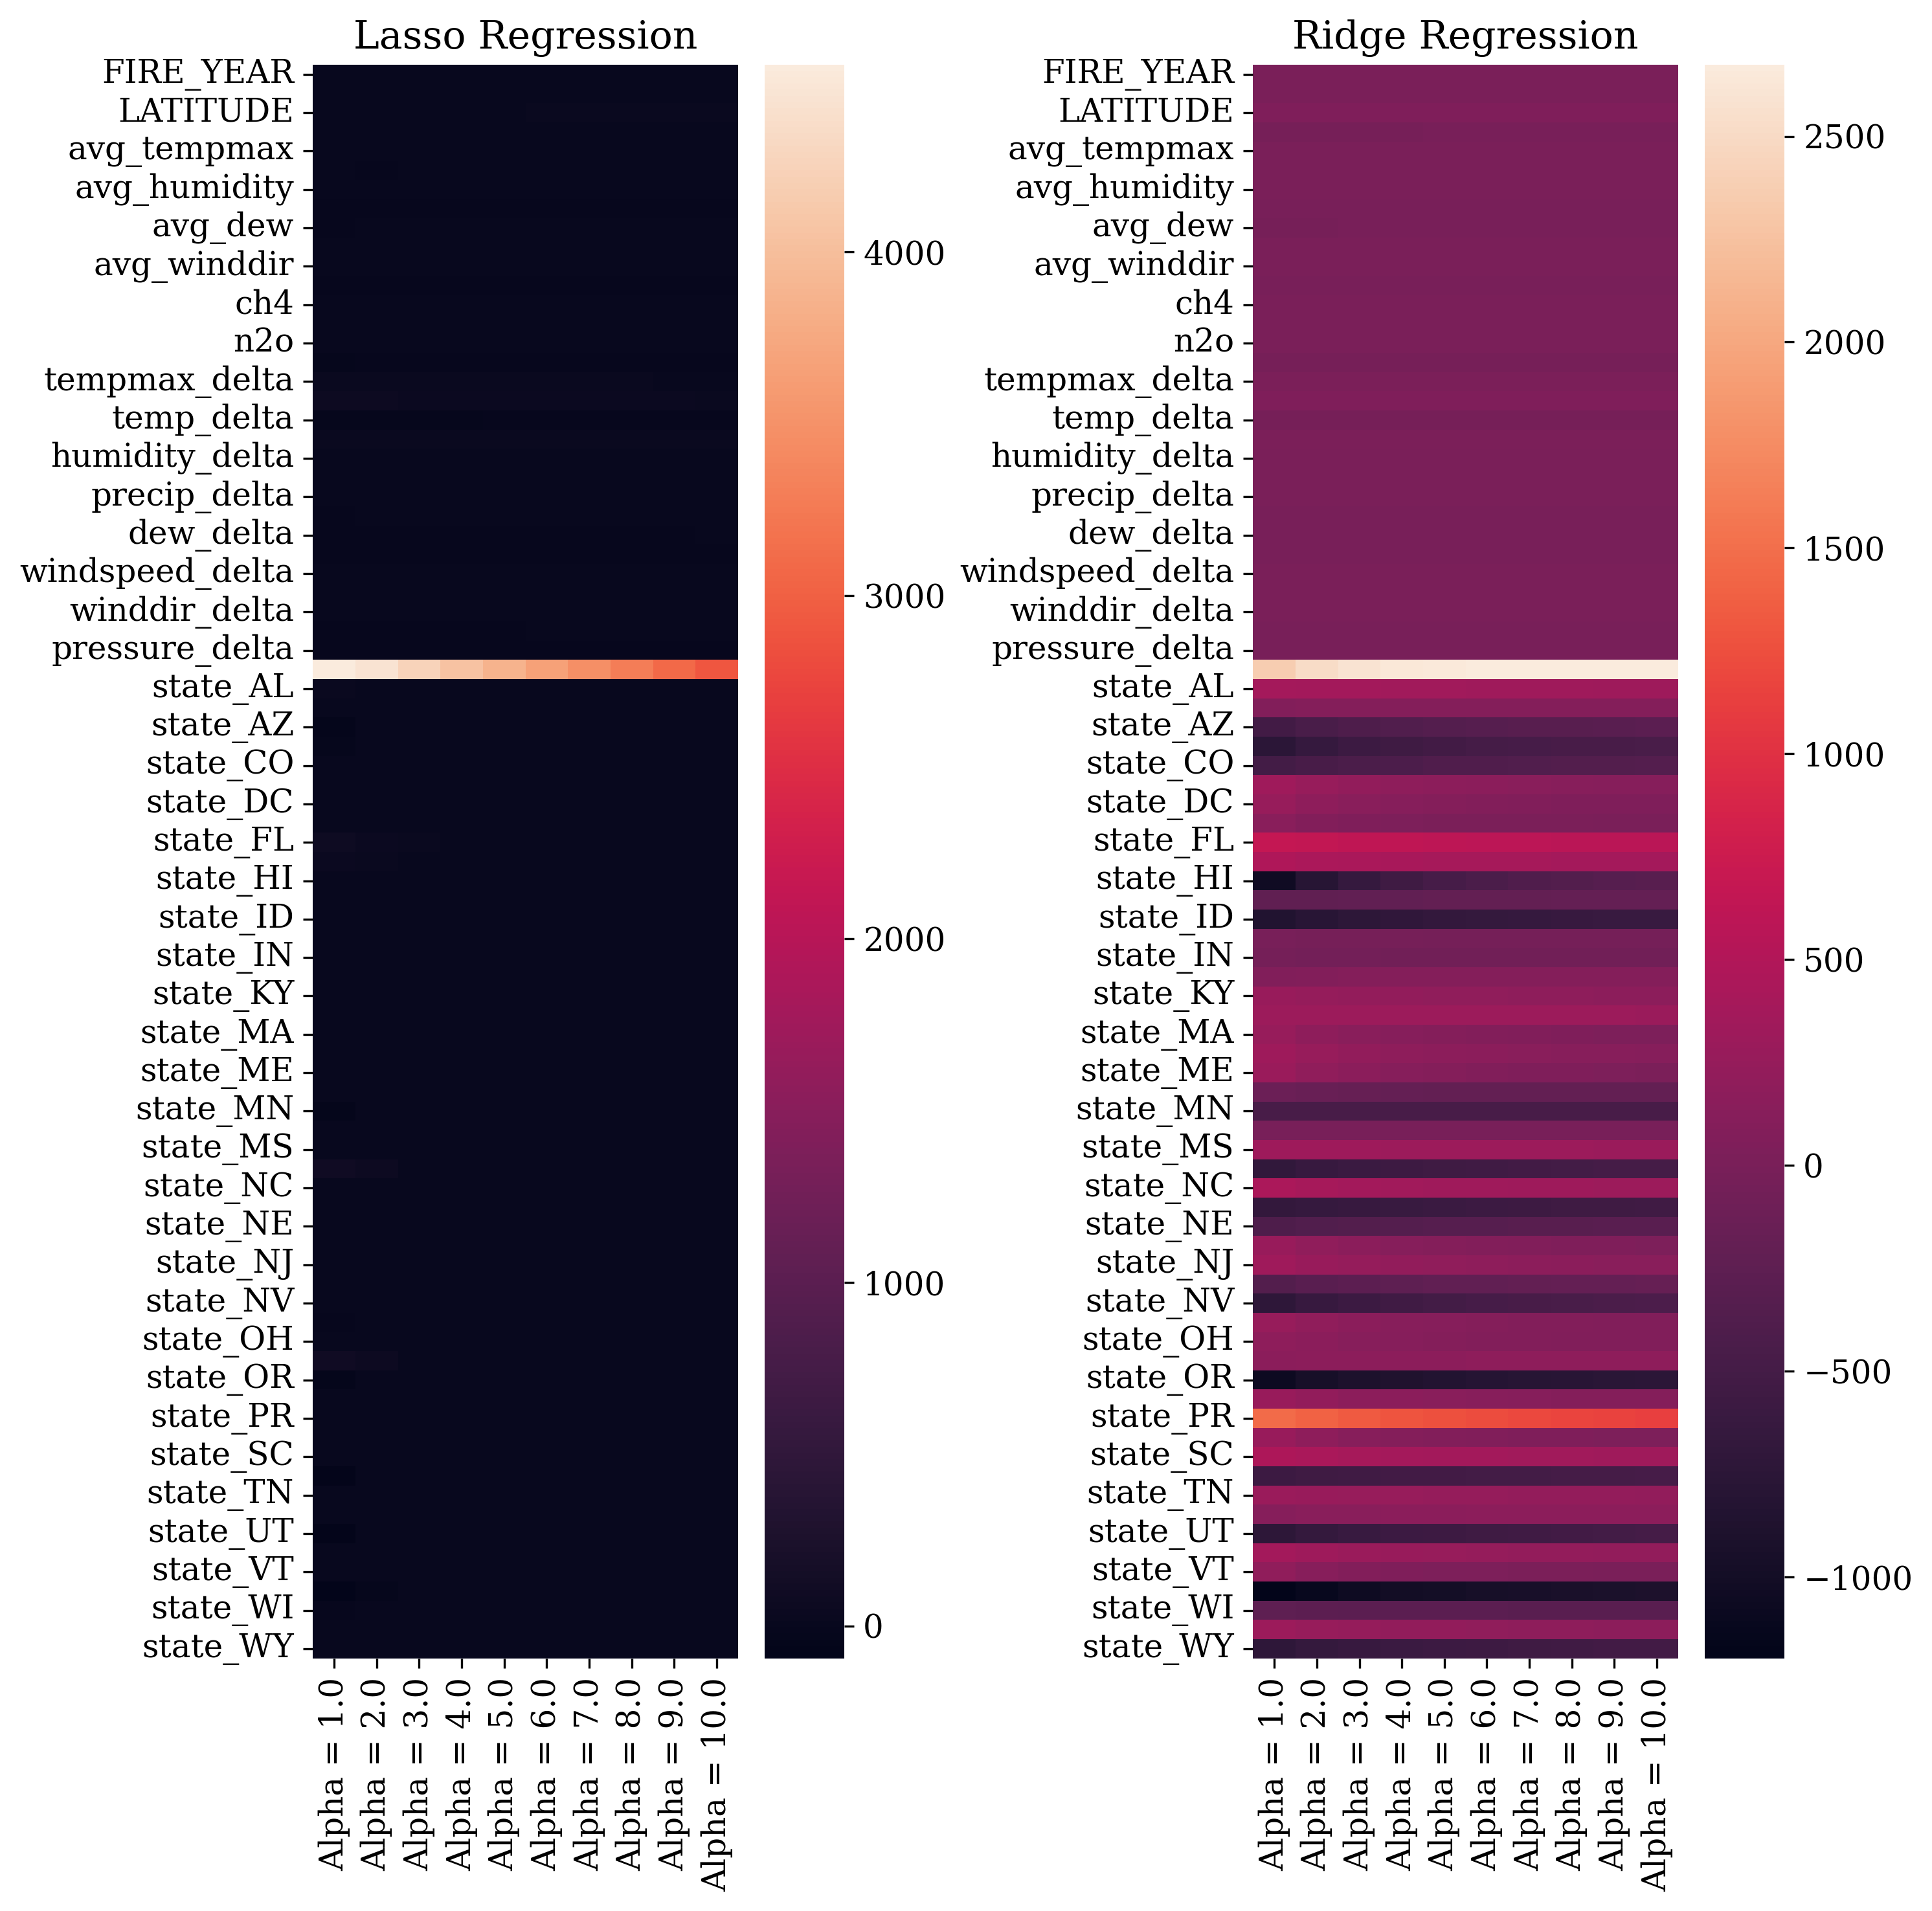

In [190]:
plt.subplots(1, 2, figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Lasso Regression')
sns.heatmap(lasso_df)

plt.subplot(1, 2, 2)
plt.title('Ridge Regression')
sns.heatmap(ridge_df)
plt.show()

## Baseline Logistic Regression

In [158]:
X_rem, X_test,y_rem, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_validatoin, y_train, y_validation = train_test_split(X_rem, y_rem, test_size=0.3, stratify=y_rem)

In [159]:
X_train_transformed = col_transformer.transform(X_train)
X_validation_transformed = col_transformer.transform(X_validation)

In [160]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=10000)

In [161]:
logreg.score(X_validation_transformed, y_validation)

0.46223021582733814

In [162]:
X_test_transformed =  col_transformer.transform(X_test)

In [163]:
logreg.score(X_test_transformed, y_test)

0.5655718053224646

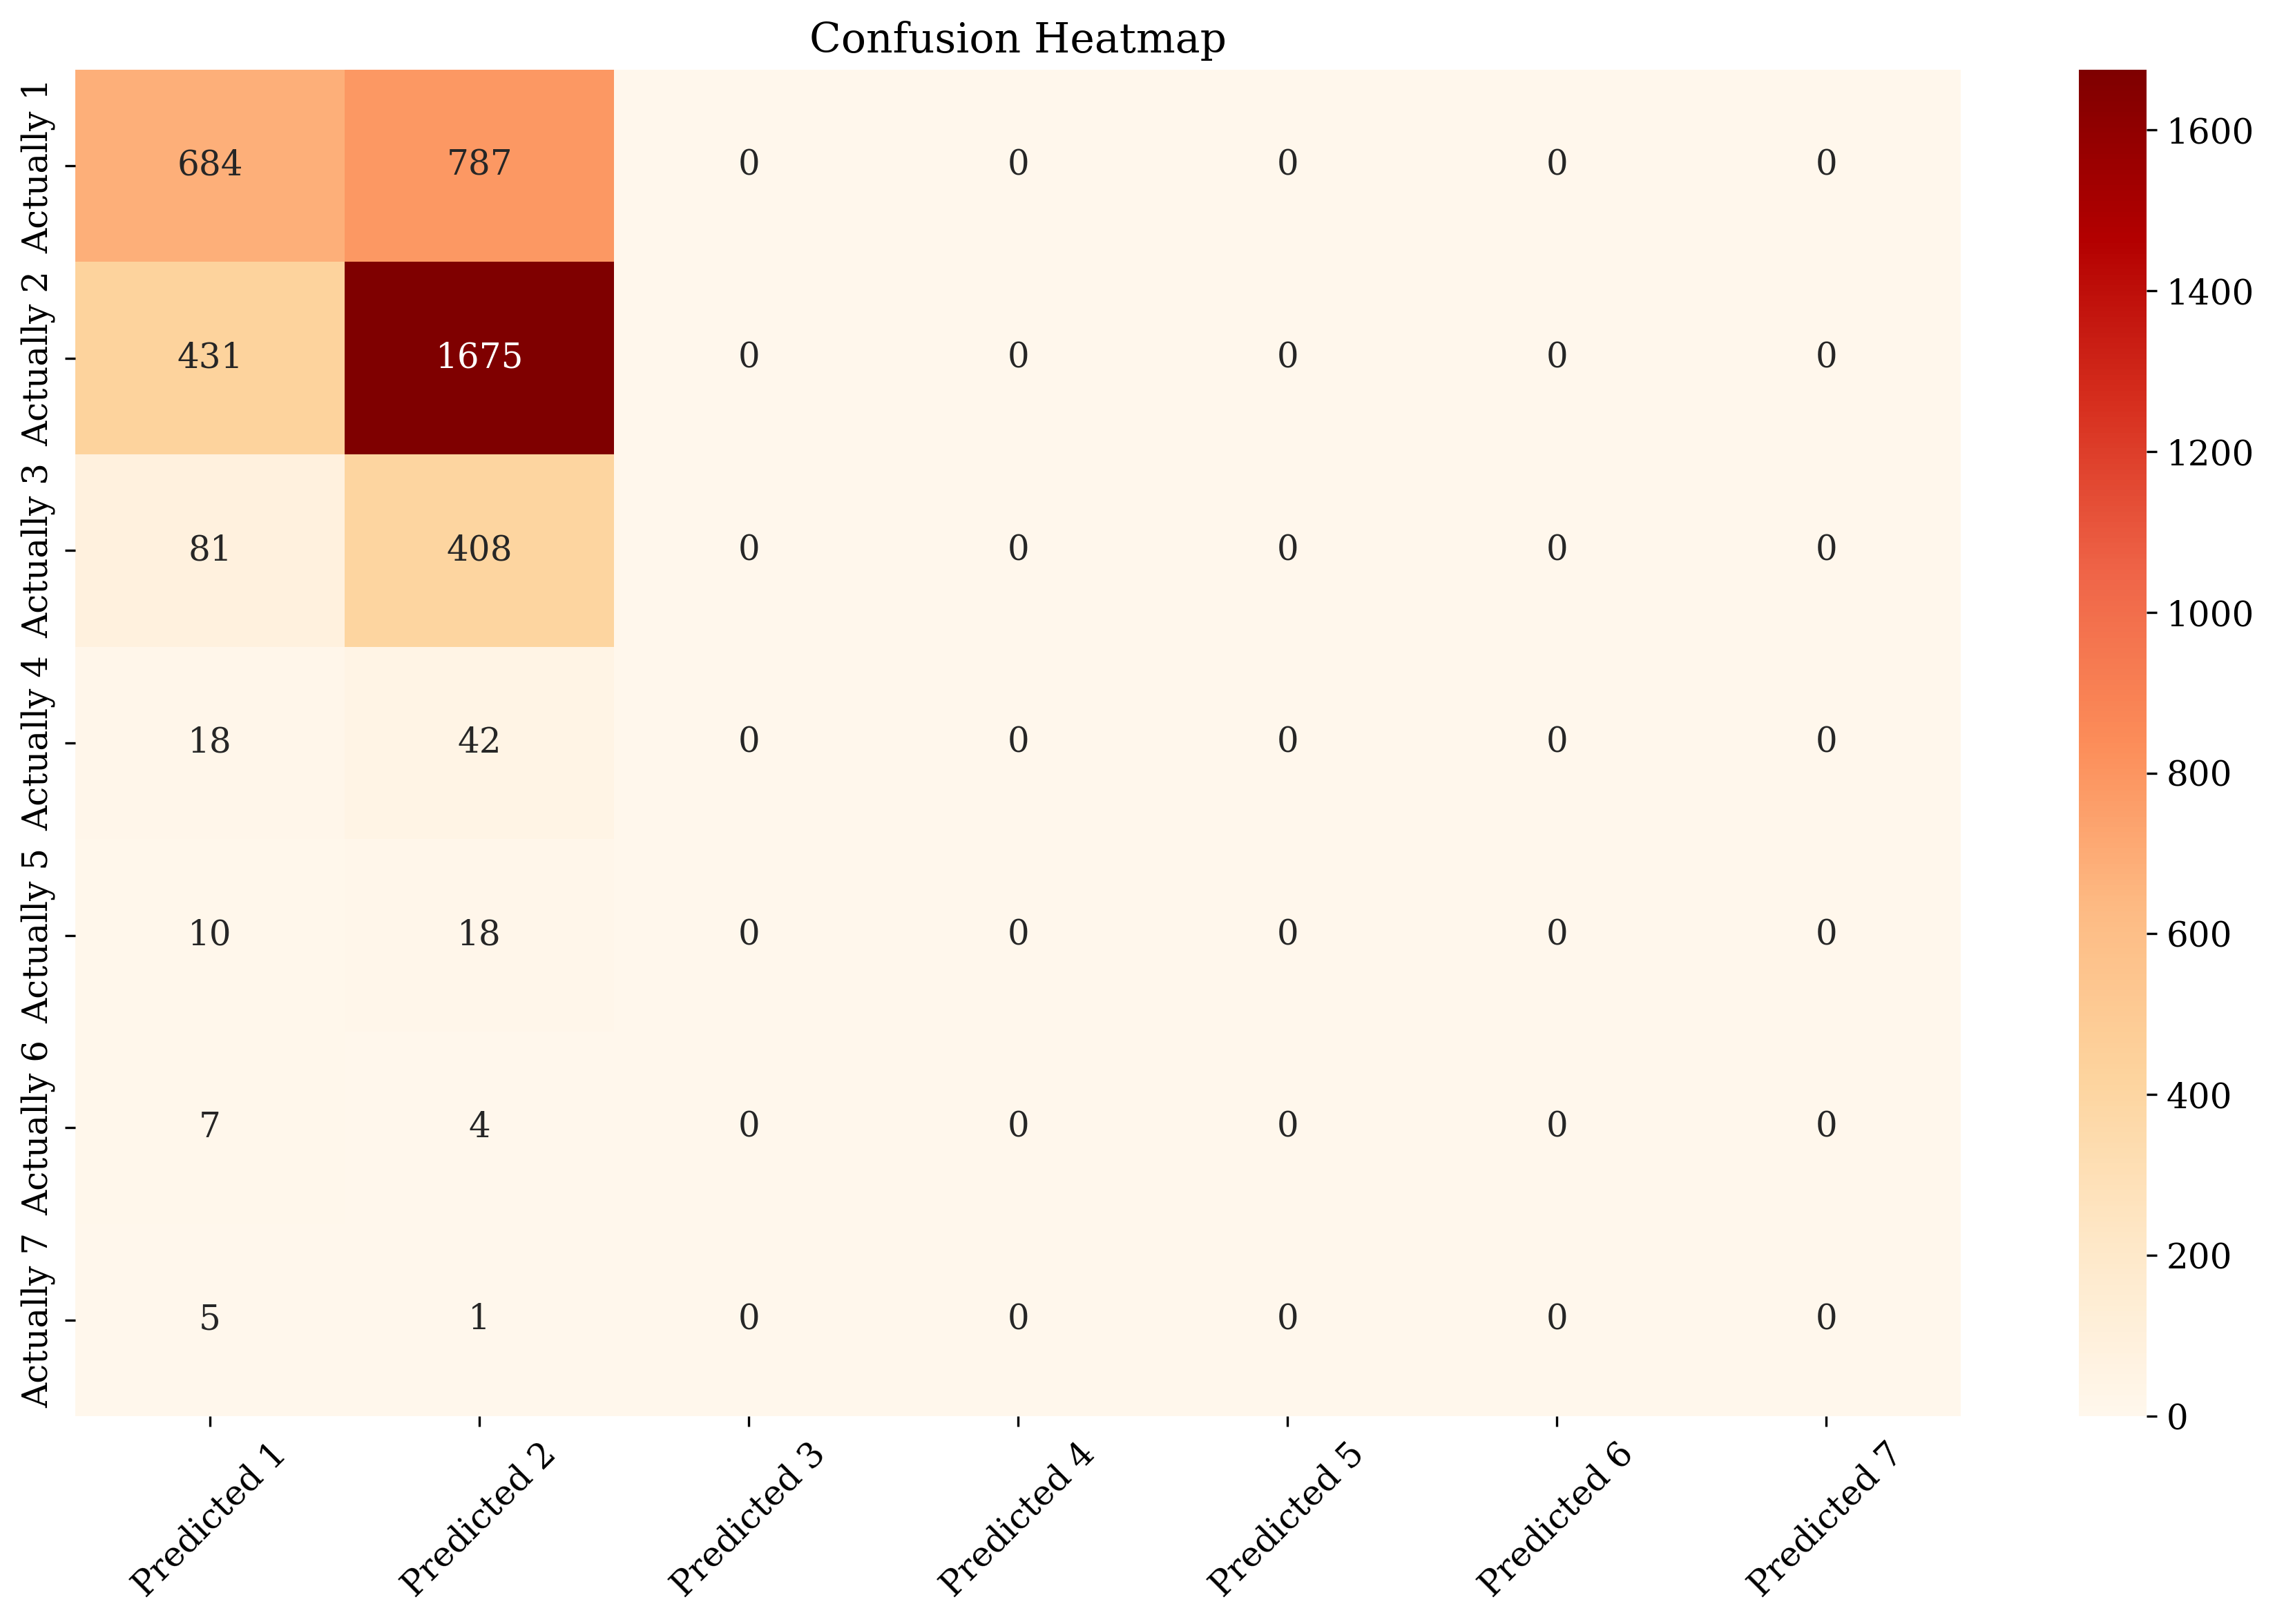

In [164]:
from sklearn.metrics import confusion_matrix

# Make classifications based on the test features, and assign the classifications to a variable
y_pred = logreg.predict(X_test_transformed)

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [f'Actually {i}' for i in range(1, 8)]
confusion_df.columns = [f'Predicted {i}' for i in range(1, 8)]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.xticks(rotation=45)
plt.title('Confusion Heatmap')
plt.savefig('figs/confusion_heatmap_1.jpg')
plt.show()